In [ ]:
# ======================================================
# UPDATED NOTEBOOK INDEX (WITH EXPLORATORY VISUALS)
# ======================================================

# 0. Imports & Configuration
# 1. Load Qualifier Micro Data (2025 & 2026)
# 2. Historical Macro Data & Trend Visualization
# 3. Summary Statistics (2025 & 2026 Qualifiers)
# 4. Feature Harmonization
# 5. Feature Engineering
# 6. Feature Matrices (2025 & 2026)
# 7. Train / Dev / Test Split + Scaling
# 8. Threshold Tuning Helper
# 9. Bootstrap Metric Confidence Intervals
# 10. Logistic Regression Applicant Model
# 11. Test-Set Applicant Counts (Logit)
# 12. Random Forest & Gradient Boosting Models
# 13. Test-Set Applicant Counts (RF & GB)
# 14. Baseline Models (Sanity Checks)
# 15. K-Fold Cross-Validation
# 16. 2026 Applicant Predictions + Confidence Intervals
# 17. Variable Importance Analysis
# 18. Precision–Recall Curves & Threshold Tradeoffs
# 19. Micro Cutoff Model (Generic + Bootstrap)
# 20. Micro Cutoff — 2025 Validation
# 21. Micro Cutoff — 2026 Prediction
# 22. Micro Cutoff Distribution Plots
# 23. Macro Cutoff Model (OLS)
# 24. Majors-Only Modeling (Optional)
# 25. Majors vs Non-Majors Distribution Comparisons
# 26. Descriptive Statistics Helper
# 27. Exploratory Visuals — Age, Race, & Buffer Distributions
# Final Summary Block


In [ ]:
# ============================
# 0. Imports & Configuration
# ============================

# Numerical computing and array operations
import numpy as np

# Data manipulation and tabular data handling
import pandas as pd

# Core plotting library
import matplotlib.pyplot as plt

# Statistical data visualization
import seaborn as sns

# Train/test splitting and cross-validation utilities
from sklearn.model_selection import (
    train_test_split,        # split data into train and test sets
    StratifiedKFold,         # stratified k-fold cross-validation
    cross_validate,          # run CV with multiple metrics
    cross_val_score          # run CV with a single metric
)

# Feature scaling / normalization
from sklearn.preprocessing import StandardScaler

# Logistic regression classifier
from sklearn.linear_model import LogisticRegression

# Tree-based ensemble models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Baseline / naive classifier for comparison
from sklearn.dummy import DummyClassifier

# Model evaluation metrics
from sklearn.metrics import (
    classification_report,   # precision/recall/F1 summary
    confusion_matrix,        # confusion matrix
    roc_auc_score,           # ROC-AUC score
    precision_score,         # precision metric
    recall_score,            # recall metric
    f1_score,                # F1 score
    accuracy_score,          # accuracy metric
    precision_recall_curve,  # precision-recall curve points
    auc,                     # area under a curve
    mean_absolute_error,     # MAE (for regression-style evaluation)
    mean_squared_error,      # MSE (for regression-style evaluation)
)

# Statistical modeling (e.g., interpretable logistic regression)
import statsmodels.api as sm

# ----------------------------
# Reproducibility
# ----------------------------

# Fixed random seed for consistency across runs
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Random number generator for bootstrap resampling
rng = np.random.default_rng(RANDOM_STATE)

# ----------------------------
# Plotting defaults
# ----------------------------

# Title font size
plt.rcParams["axes.titlesize"] = 16

# Axis label font size
plt.rcParams["axes.labelsize"] = 14

# Legend font size
plt.rcParams["legend.fontsize"] = 12

# X-axis tick label size
plt.rcParams["xtick.labelsize"] = 10

# Y-axis tick label size
plt.rcParams["ytick.labelsize"] = 10


In [ ]:
# ======================================================
# 1. LOAD DATA: 2025 & 2026 QUALIFIER DATA
# ======================================================

# Load 2025 qualifier data from CSV
df25 = pd.read_csv("Boston_Marathon_2025_Qualifiers", low_memory=False)

# Load 2026 qualifier data from CSV
df26 = pd.read_csv("Boston_Marathon_2026_Qualifiers", low_memory=False)

# Remove duplicate runners based on Name–Country combination (proxy for uniqueness)
df25 = df25.drop_duplicates(subset=["Name", "Country"])
df26 = df26.drop_duplicates(subset=["Name", "Country"])

# Print dataset dimensions after de-duplication
print("2025 qualifiers shape:", df25.shape)
print("2026 qualifiers shape:", df26.shape)


2025 qualifiers shape: (107078, 37)
2026 qualifiers shape: (97375, 41)


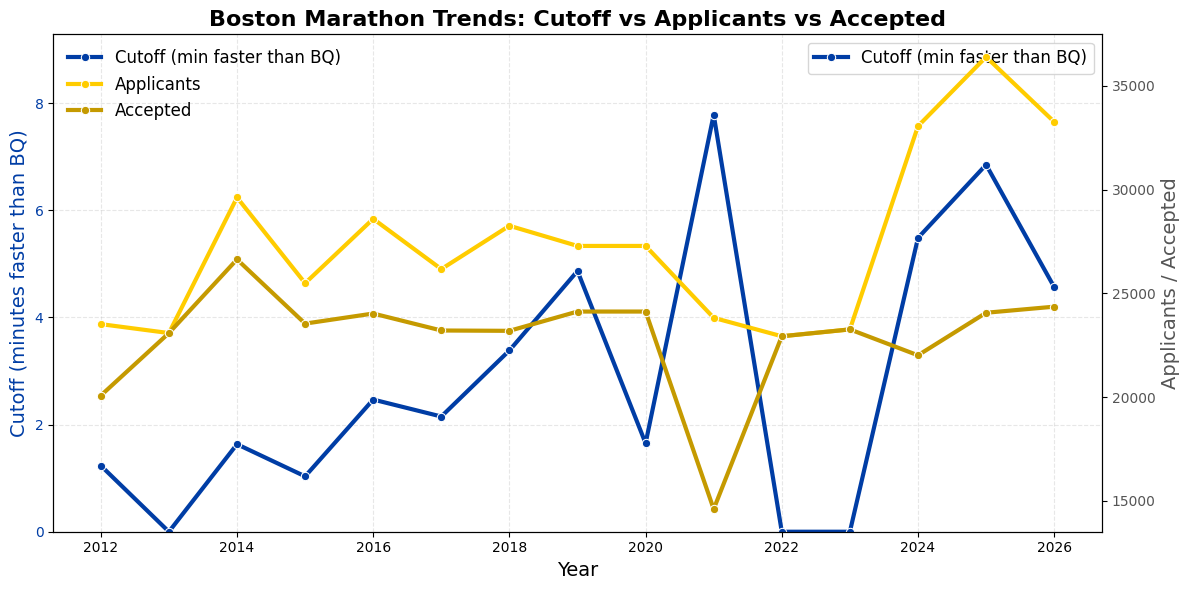

In [ ]:
# ======================================================
# 2. HISTORICAL MACRO DATA & BASIC PLOT
# ======================================================

# Year-level historical data used for the macro cutoff model
# Cutoff_min = minutes faster than BQ required for acceptance
# Applicants = total number of applicants
# Accepted = total number of runners accepted by BAA
hist_data = [
    {"Year": 2012, "Cutoff_min": 1 + 14/60, "Applicants": 23521, "Accepted": 20081},
    {"Year": 2013, "Cutoff_min": 0.00,        "Applicants": 23091, "Accepted": 23091},
    {"Year": 2014, "Cutoff_min": 1 + 38/60, "Applicants": 29622, "Accepted": 26640},
    {"Year": 2015, "Cutoff_min": 1 +  2/60, "Applicants": 25493, "Accepted": 23546},
    {"Year": 2016, "Cutoff_min": 2 + 28/60, "Applicants": 28594, "Accepted": 24032},
    {"Year": 2017, "Cutoff_min": 2 +  9/60, "Applicants": 26171, "Accepted": 23214},
    {"Year": 2018, "Cutoff_min": 3 + 23/60, "Applicants": 28260, "Accepted": 23198},
    {"Year": 2019, "Cutoff_min": 4 + 52/60, "Applicants": 27288, "Accepted": 24127},
    {"Year": 2020, "Cutoff_min": 1 + 39/60, "Applicants": 27288, "Accepted": 24127},
    {"Year": 2021, "Cutoff_min": 7 + 47/60, "Applicants": 23824, "Accepted": 14609},
    {"Year": 2022, "Cutoff_min": 0.00,        "Applicants": 22936, "Accepted": 22936},
    {"Year": 2023, "Cutoff_min": 0.00,        "Applicants": 23267, "Accepted": 23267},
    {"Year": 2024, "Cutoff_min": 5 + 29/60, "Applicants": 33058, "Accepted": 22019},
    {"Year": 2025, "Cutoff_min": 6 + 51/60, "Applicants": 36393, "Accepted": 24069},
    {"Year": 2026, "Cutoff_min": 4 + 34/60, "Applicants": 33267, "Accepted": 24362},
]

# Convert list of dictionaries to DataFrame
df_hist = pd.DataFrame(hist_data)

# ----------------------------
# Visualization
# ----------------------------

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cutoff on left y-axis
sns.lineplot(
    data=df_hist,
    x="Year",
    y="Cutoff_min",
    marker="o",
    linewidth=3,
    color="#003DA5",
    label="Cutoff (min faster than BQ)",
    ax=ax1,
)
ax1.set_ylabel("Cutoff (minutes faster than BQ)", color="#003DA5")
ax1.tick_params(axis="y", labelcolor="#003DA5")
ax1.set_ylim(0, df_hist["Cutoff_min"].max() + 1.5)

# Create secondary y-axis for applicants and accepted
ax2 = ax1.twinx()

# Plot applicants on right y-axis
sns.lineplot(
    data=df_hist,
    x="Year",
    y="Applicants",
    marker="o",
    linewidth=3,
    color="#FFCC00",
    label="Applicants",
    ax=ax2,
)

# Plot accepted runners on right y-axis
sns.lineplot(
    data=df_hist,
    x="Year",
    y="Accepted",
    marker="o",
    linewidth=3,
    color="#C59A00",
    label="Accepted",
    ax=ax2,
)
ax2.set_ylabel("Applicants / Accepted", color="#555")
ax2.tick_params(axis="y", labelcolor="#555")

# Set plot title
plt.title(
    "Boston Marathon Trends: Cutoff vs Applicants vs Accepted",
    fontsize=16,
    weight="bold",
)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=False)

# Add light grid for readability
ax1.grid(True, linestyle="--", alpha=0.3)

# Adjust layout and display plot
plt.tight_layout()
plt.show()


In [ ]:
# ======================================================
# 3. BASIC SUMMARY OF 2025 & 2026 QUALIFIER SETS
# ======================================================

# ----------------------------
# 2025 Qualifiers (training year)
# ----------------------------

# Print header for clarity
print("====================================================")
print("INFO: 2025 Boston Marathon Qualifiers (Training Year)")
print("====================================================")

# Count number of applicants in 2025 data
num_applied_2025 = df25["Applied"].sum()

# Total number of rows (runners) in dataset
total_2025 = len(df25)

# Print basic dataset statistics
print(f"Rows in dataset: {total_2025:,}")
print(f"Applicants in dataset: {num_applied_2025:,}")
print(f"Proportion who applied: {num_applied_2025 / total_2025:.2%}")

# Print official BAA benchmarks for comparison
print("ACTUAL applicants (BAA): 36,393")
print("ACTUAL applicants accepted: 24,069\n")

# ----------------------------
# 2026 Qualifiers (prediction year)
# ----------------------------

# Print header for clarity
print("====================================================")
print("INFO: 2026 Boston Marathon Qualifiers (Prediction Yr)")
print("====================================================")

# Total number of rows (runners) in dataset
total_2026 = len(df26)

# Check whether application status exists in 2026 data
if "Applied" in df26.columns:
    # Count applicants if column is present
    num_applied_2026 = df26["Applied"].sum()
    prop_2026 = num_applied_2026 / total_2026
else:
    # Fallback if application data is unavailable
    num_applied_2026 = "N/A"
    prop_2026 = "N/A"

# Print basic dataset statistics
print(f"Rows in dataset: {total_2026:,}")
print(f"Applicants in dataset (if present): {num_applied_2026}")
print(f"Proportion applied (if present): {prop_2026}")

# Print official BAA benchmarks for comparison
print("ACTUAL applicants (BAA): 33,267")
print("ACTUAL applicants accepted: 24,362")
print("====================================================\n")


INFO: 2025 Boston Marathon Qualifiers (Training Year)
Rows in dataset: 107,078
Applicants in dataset: 17,178
Proportion who applied: 16.04%
ACTUAL applicants (BAA): 36,393
ACTUAL applicants accepted: 24,069

INFO: 2026 Boston Marathon Qualifiers (Prediction Yr)
Rows in dataset: 97,375
Applicants in dataset (if present): 0.0
Proportion applied (if present): 0.0
ACTUAL applicants (BAA): 33,267
ACTUAL applicants accepted: 24,362



In [ ]:
# ======================================================
# 4. HARMONIZE DISTANCE COLUMNS
# ======================================================

# Create explicit copies to avoid chained assignment issues
df25 = df25.copy()
df26 = df26.copy()

# Map 2025 distance column to common name
if "Race_Distance_to_Boston_mi" in df25.columns:
    df25["dist_to_boston_mi"] = df25["Race_Distance_to_Boston_mi"]

# Map 2026 distance column to common name
if "distance_to_boston_from_race" in df26.columns:
    df26["dist_to_boston_mi"] = df26["distance_to_boston_from_race"]

# Ensure distance column is numeric in both datasets
df25["dist_to_boston_mi"] = df25["dist_to_boston_mi"].astype(float)
df26["dist_to_boston_mi"] = df26["dist_to_boston_mi"].astype(float)

# Confirm harmonization step
print("Distance column harmonized to 'dist_to_boston_mi' in both datasets.")


Distance column harmonized to 'dist_to_boston_mi' in both datasets.


In [ ]:
# ======================================================
# 5. FEATURE ENGINEERING FUNCTION
# ======================================================
def make_features(df: pd.DataFrame, is_2025: bool = True):
    """
    Build feature matrix X and, optionally, label vector y (Applied).

    Features:
      • Age
      • is_male (Gender == 1)
      • is_usa (Country == 'USA')
      • Count (number of qualifying marathons)
      • Ran_Previous_Boston (binary)
      • dist_to_boston_mi (race proximity to Boston)
      • Buffer bins based on max_buffer (seconds)
    """
    # Work on a copy to avoid mutating original data
    df = df.copy()

    # Convert buffer from seconds to minutes
    df["buffer_minutes"] = df["max_buffer"] / 60.0

    # Compute buffer as percent of BQ time (optional diagnostic feature)
    df["buffer_percentage"] = np.where(
        df["BQ"] > 0,
        (df["Buffer"] / df["BQ"]) * 100.0,
        np.nan,
    )

    # Create binary indicator for USA-based runners
    df["is_usa"] = (df["Country"] == "USA").astype(int)

    # Create binary indicator for male runners
    df["is_male"] = (df["Gender"] == 1).astype(int)

    # Add squared age term to allow nonlinear age effects
    df["age_squared"] = df["Age"] ** 2

    # Create buffer bins (in seconds) to capture nonlinear buffer effects
    df["buffer_0_500"] = (df["max_buffer"] >= 0) & (df["max_buffer"] < 500)
    df["buffer_500_1000"] = (df["max_buffer"] >= 500) & (df["max_buffer"] < 1000)
    df["buffer_1000_1500"] = (df["max_buffer"] >= 1000) & (df["max_buffer"] < 1500)
    df["buffer_1500_2000"] = (df["max_buffer"] >= 1500) & (df["max_buffer"] < 2000)

    # Convert buffer bin booleans to integers
    df[[
        "buffer_0_500", "buffer_500_1000",
        "buffer_1000_1500", "buffer_1500_2000"
    ]] = df[[
        "buffer_0_500", "buffer_500_1000",
        "buffer_1000_1500", "buffer_1500_2000"
    ]].astype(int)

    # Define final set of model features
    feature_cols = [
        "Age", "is_male", "is_usa",
        "Count", "Ran_Previous_Boston", "dist_to_boston_mi",
        "buffer_0_500", "buffer_500_1000",
        "buffer_1000_1500", "buffer_1500_2000",
    ]

    # Build feature matrix and drop rows with missing values
    X = df[feature_cols].copy()
    X = X.dropna()

    # Align dataframe to rows retained in feature matrix
    df = df.loc[X.index]

    # Return labels only for 2025 (training) data
    if is_2025:
        y = df["Applied"].astype(int)
        return X, y, df
    else:
        return X, None, df


In [ ]:
# ======================================================
# 6. BUILD FEATURE MATRICES FOR 2025 & 2026
# ======================================================

# Generate features and labels for 2025 (training data)
X25, y25, df25_clean = make_features(df25, is_2025=True)

# Generate features for 2026 (prediction data, no labels)
X26, _, df26_clean = make_features(df26, is_2025=False)

# Print dimensions of feature matrices and labels
print("Feature matrix 2025:", X25.shape, "| y:", y25.shape)
print("Feature matrix 2026:", X26.shape)

# Print application rate in 2025 (class balance)
print("Positive rate 2025 (Applied=1):", y25.mean())

# ----------------------------
# Column consistency checks
# ----------------------------

# Collect column names from raw 2025 and 2026 datasets
cols25 = set(df25.columns)
cols26 = set(df26.columns)

# Columns present only in 2025
print("\nColumns in 2025 but NOT in 2026:")
print(sorted(list(cols25 - cols26)))

# Columns present only in 2026
print("\nColumns in 2026 but NOT in 2025:")
print(sorted(list(cols26 - cols25)))

# Columns shared by both datasets
print("\nShared columns:")
print(sorted(list(cols25 & cols26)))


Feature matrix 2025: (107035, 10) | y: (107035,)
Feature matrix 2026: (91336, 10)
Positive rate 2025 (Applied=1): 0.1603587611528939

Columns in 2025 but NOT in 2026:
['Race_Distance_to_Boston_mi', 'is_usa']

Columns in 2026 but NOT in 2025:
['Average_Buffer', 'Min_Distance', 'Unnamed: 0', 'distance_to_boston_from_race', 'lat', 'lon']

Shared columns:
['Age', 'Age Group', 'Applied', 'BQ', 'BQ_2013', 'BQ_2020', 'BQ_2026', 'Buffer', 'City', 'Count', 'Country', 'Date', 'Finish', 'Gender', 'GenderPlace', 'Name', 'OverallPlace', 'Qualified', 'Race', 'RaceCity', 'RaceCountry', 'RaceState', 'Ran_Previous_Boston', 'State', 'TotalParticipants', 'Year', 'Zip', 'athleteId', 'buffer_0_500', 'buffer_1000_1500', 'buffer_1500_2000', 'buffer_2000_plus', 'buffer_500_1000', 'dist_to_boston_mi', 'max_buffer', 'resultId']


In [ ]:
# ======================================================
# 7. TRAIN / DEV / TEST SPLIT (70/10/20) + SCALING
# ======================================================

# Split 2025 data into training (70%) and temporary (30%) sets
# Stratification preserves the Applied class balance
X_train, X_temp, y_train, y_temp = train_test_split(
    X25, y25,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y25,
)

# Split temporary set into development (10%) and test (20%) sets
# 2/3 of the 30% temporary set becomes the final test set
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp,
    test_size=2/3,
    random_state=RANDOM_STATE,
    stratify=y_temp,
)

# Print shapes of each split
print("\nTrain:", X_train.shape, y_train.shape)
print("Dev:  ", X_dev.shape,   y_dev.shape)
print("Test: ", X_test.shape,  y_test.shape)

# Print class balance across splits
print("\nPositive rates:")
print("Train:", y_train.mean())
print("Dev:  ", y_dev.mean())
print("Test: ", y_test.mean())

# ----------------------------
# Feature scaling
# ----------------------------

# Initialize standard scaler (zero mean, unit variance)
scaler = StandardScaler()

# Fit scaler on training data and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled   = scaler.transform(X_dev)
X_test_scaled  = scaler.transform(X_test)

# Print shapes of scaled feature matrices
print("\nScaled shapes:")
print("Train:", X_train_scaled.shape)
print("Dev:  ", X_dev_scaled.shape)
print("Test: ", X_test_scaled.shape)



Train: (74924, 10) (74924,)
Dev:   (10703, 10) (10703,)
Test:  (21408, 10) (21408,)

Positive rates:
Train: 0.1603625006673429
Dev:   0.16032887975334018
Test:  0.16036061285500747

Scaled shapes:
Train: (74924, 10)
Dev:   (10703, 10)
Test:  (21408, 10)


In [1]:
# ======================================================
# 8. HELPER: TUNE THRESHOLD ON DEV (MAX F1)
# ======================================================
def tune_threshold_on_dev(dev_probs, y_dev, satep=0.005):
    """
    Search thresholds in [0, 1] to maximize F1 on dev set.

    Returns
    -------
    best_t : threshold that maximizes F1
    best_f1 : corresponding F1 score
    """
    # Initialize best threshold and best F1 score
    best_t = 0.5
    best_f1 = 0.0

    # Loop over candidate thresholds from 0 to 1
    # NOTE: uses `step` below; this assumes `step` is defined (potential typo vs `satep`)
    for t in np.linspace(0, 1, int(1/step) + 1):
        # Convert probabilities to binary predictions at threshold t
        preds_t = (dev_probs >= t).astype(int)

        # Compute F1 score at this threshold
        f1_t = f1_score(y_dev, preds_t, zero_division=1)

        # Update best threshold if F1 improves
        if f1_t > best_f1:
            best_f1 = f1_t
            best_t = t

    # Return optimal threshold and its F1 score
    return best_t, best_f1


In [ ]:
# ======================================================
# 9. HELPER: BOOTSTRAP METRIC CONFIDENCE INTERVALS
# ======================================================
def bootstrap_metric_ci(
    y_true,
    y_score,
    threshold,
    n_boot=1000,
    alpha=0.05,
):
    """
    Bootstrap F1 and ROC-AUC on (y_true, y_score) using resampling of indices.

    Returns
    -------
    dict with point estimates and confidence interval bounds
    """
    # Convert inputs to NumPy arrays
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    # Number of observations
    n = len(y_true)

    # Containers for bootstrap statistics
    f1_values = []
    auc_values = []

    # Bootstrap resampling loop
    for _ in range(n_boot):
        # Sample indices with replacement
        idx = rng.integers(0, n, n)

        # Resampled true labels and scores
        yt = y_true[idx]
        ys = y_score[idx]

        # Convert scores to binary predictions using fixed threshold
        yp = (ys >= threshold).astype(int)

        # Compute ROC-AUC (guard against degenerate samples)
        try:
            auc_val = roc_auc_score(yt, ys)
        except ValueError:
            auc_val = np.nan

        # Compute F1 score for this bootstrap sample
        f1_values.append(f1_score(yt, yp, zero_division=0))
        auc_values.append(auc_val)

    # Convert lists to arrays for vectorized operations
    f1_values = np.array(f1_values)
    auc_values = np.array(auc_values)

    # Helper function to compute percentile-based confidence intervals
    def ci(x):
        lo = np.nanpercentile(x, 100 * (alpha / 2))
        hi = np.nanpercentile(x, 100 * (1 - alpha / 2))
        return lo, hi

    # Compute confidence intervals for each metric
    f1_ci_lo, f1_ci_hi = ci(f1_values)
    auc_ci_lo, auc_ci_hi = ci(auc_values)

    # Compute point estimates on full (non-bootstrapped) sample
    point_f1 = f1_score(
        y_true,
        (y_score >= threshold).astype(int),
        zero_division=0,
    )
    point_auc = roc_auc_score(y_true, y_score)

    # Return metrics and confidence intervals
    return {
        "F1": point_f1,
        "F1_CI": (f1_ci_lo, f1_ci_hi),
        "ROC_AUC": point_auc,
        "ROC_AUC_CI": (auc_ci_lo, auc_ci_hi),
    }


In [ ]:
# ======================================================
# 10. LOGISTIC REGRESSION MODEL (MAIN APPLICANT MODEL)
# ======================================================

# Initialize logistic regression with class balancing for imbalanced data
logit_model = LogisticRegression(
    class_weight="balanced",   # adjust for unequal Applied / Not Applied classes
    max_iter=2000,             # increase iterations to ensure convergence
    solver="lbfgs",            # stable solver for logistic regression
    random_state=RANDOM_STATE, # reproducibility
)

# Fit model on scaled training data
logit_model.fit(X_train_scaled, y_train)

# ----------------------------
# DEV set: probability predictions and threshold tuning
# ----------------------------

# Predicted probabilities for the positive class on dev set
dev_proba_logit = logit_model.predict_proba(X_dev_scaled)[:, 1]

# Tune classification threshold to maximize F1 on dev set
best_threshold_logit, best_f1_dev_logit = tune_threshold_on_dev(
    dev_proba_logit,
    y_dev,
)

# Print dev-set tuning results
print("\n=== LOGISTIC REGRESSION (Logit) ===")
print("Best DEV threshold:", round(best_threshold_logit, 3))
print("Best DEV F1:", round(best_f1_dev_logit, 4))

# ----------------------------
# TEST set evaluation
# ----------------------------

# Predicted probabilities for the positive class on test set
test_proba_logit = logit_model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary predictions using tuned threshold
test_pred_logit = (test_proba_logit >= best_threshold_logit).astype(int)

# Print standard test-set performance metrics
print("\n--- TEST SET RESULTS (Logit) ---")
print(f"ROC-AUC:   {roc_auc_score(y_test, test_proba_logit):.4f}")
print(f"Precision: {precision_score(y_test, test_pred_logit):.4f}")
print(f"Recall:    {recall_score(y_test, test_pred_logit):.4f}")
print(f"F1 Score:  {f1_score(y_test, test_pred_logit):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred_logit))

# ----------------------------
# Bootstrap confidence intervals on TEST set
# ----------------------------

# Compute bootstrap CIs for F1 and ROC-AUC
logit_metric_ci = bootstrap_metric_ci(
    y_true=y_test,
    y_score=test_proba_logit,
    threshold=best_threshold_logit,
    n_boot=500,      # number of bootstrap resamples
    alpha=0.05,      # 95% confidence intervals
)

# Print bootstrap confidence intervals
print("\n--- TEST METRIC CIs (Logit, 95% bootstrap) ---")
print(
    f"F1: {logit_metric_ci['F1']:.3f} "
    f"[{logit_metric_ci['F1_CI'][0]:.3f}, {logit_metric_ci['F1_CI'][1]:.3f}]"
)
print(
    f"ROC-AUC: {logit_metric_ci['ROC_AUC']:.3f} "
    f"[{logit_metric_ci['ROC_AUC_CI'][0]:.3f}, {logit_metric_ci['ROC_AUC_CI'][1]:.3f}]"
)

# ----------------------------
# Store results for later reuse
# ----------------------------

# Save model, threshold, and test predictions in a dictionary
logit_results = {
    "model": logit_model,
    "threshold": best_threshold_logit,
    "test_proba": test_proba_logit,
    "test_pred": test_pred_logit,
}



=== LOGISTIC REGRESSION (Logit) ===
Best DEV threshold: 0.63
Best DEV F1: 0.4617

--- TEST SET RESULTS (Logit) ---
ROC-AUC:   0.7976
Precision: 0.3753
Recall:    0.5928
F1 Score:  0.4596
Confusion Matrix:
 [[14587  3388]
 [ 1398  2035]]

--- TEST METRIC CIs (Logit, 95% bootstrap) ---
F1: 0.460 [0.446, 0.472]
ROC-AUC: 0.798 [0.790, 0.805]


In [ ]:
# ======================================================
# 11. TEST SET APPLICANT COUNTS (Logit)
# ======================================================

# Count number of applicants predicted using binary threshold
binary_test_apps_logit = test_pred_logit.sum()

# Compute expected number of applicants as sum of predicted probabilities
expected_test_apps_logit = test_proba_logit.sum()

# Actual number of applicants in the test set
actual_test_apps = y_test.sum()

# Print comparison of actual vs predicted applicant counts
print("\n=== TEST SET: Applicant Predictions (Logit) ===")
print(f"Actual applicants (y_test):              {actual_test_apps:,}")
print(f"Binary predicted applicants (threshold): {binary_test_apps_logit:,}")
print(f"Expected applicants (sum of probs):      {expected_test_apps_logit:,.1f}")



=== TEST SET: Applicant Predictions (Logit) ===
Actual applicants (y_test):              3,433
Binary predicted applicants (threshold): 5,423
Expected applicants (sum of probs):      8,795.6


In [ ]:
# ======================================================
# 12. RANDOM FOREST & GRADIENT BOOSTING MODELS
# ======================================================

# ----------------------------
# Generic helper for prob models with DEV tuning
# ----------------------------
def train_prob_model_with_dev(
    model,
    X_train,
    y_train,
    X_dev,
    y_dev,
    model_name="Model",
):
    """
    Train a probabilistic classifier, tune threshold on DEV (max F1),
    and return the fitted model and optimal threshold.
    """
    # Print model header
    print(f"\n====================================")
    print(f"{model_name.upper()} — Train/Dev/Test")
    print("====================================")

    # Fit model on training data
    model.fit(X_train, y_train)

    # Predict probabilities on dev set
    dev_proba = model.predict_proba(X_dev)[:, 1]

    # Tune threshold to maximize F1 on dev set
    best_t, best_f1 = tune_threshold_on_dev(dev_proba, y_dev)

    # Print dev-set tuning results
    print(f"Best {model_name} threshold on DEV = {best_t:.3f} (F1={best_f1:.4f})")

    return model, best_t, dev_proba

# ----------------------------
# RANDOM FOREST MODEL
# ----------------------------

# Initialize Random Forest (tree-based, no scaling required)
rf = RandomForestClassifier(
    n_estimators=400,          # number of trees
    max_depth=None,            # allow full tree depth
    class_weight="balanced",   # handle class imbalance
    random_state=RANDOM_STATE, # reproducibility
    n_jobs=-1,                 # use all available cores
)

# Train RF and tune threshold on dev set
rf, rf_best_t, rf_dev_proba = train_prob_model_with_dev(
    rf, X_train, y_train, X_dev, y_dev, model_name="Random Forest"
)

# Predict probabilities on test set
rf_test_proba = rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using tuned threshold
rf_test_pred = (rf_test_proba >= rf_best_t).astype(int)

# Print test-set performance metrics
print("\n--- RANDOM FOREST TEST RESULTS ---")
print(f"ROC-AUC:   {roc_auc_score(y_test, rf_test_proba):.4f}")
print(f"Precision: {precision_score(y_test, rf_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, rf_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, rf_test_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_test_pred))

# Bootstrap confidence intervals for RF metrics
rf_metric_ci = bootstrap_metric_ci(
    y_true=y_test,
    y_score=rf_test_proba,
    threshold=rf_best_t,
    n_boot=500,
    alpha=0.05,   # 95% confidence intervals
)

# Print RF bootstrap confidence intervals
print("\n--- TEST METRIC CIs (Random Forest, 95% bootstrap) ---")
print(
    f"F1: {rf_metric_ci['F1']:.3f} "
    f"[{rf_metric_ci['F1_CI'][0]:.3f}, {rf_metric_ci['F1_CI'][1]:.3f}]"
)
print(
    f"ROC-AUC: {rf_metric_ci['ROC_AUC']:.3f} "
    f"[{rf_metric_ci['ROC_AUC_CI'][0]:.3f}, {rf_metric_ci['ROC_AUC_CI'][1]:.3f}]"
)

# Store Random Forest results
rf_results = {
    "model": rf,
    "best_threshold": rf_best_t,
    "test_proba": rf_test_proba,
    "test_pred": rf_test_pred,
}

# ----------------------------
# GRADIENT BOOSTING MODEL
# ----------------------------

# Initialize Gradient Boosting classifier
gb = GradientBoostingClassifier(
    learning_rate=0.05,        # step size shrinkage
    n_estimators=300,          # number of boosting stages
    random_state=RANDOM_STATE, # reproducibility
)

# Train GB and tune threshold on dev set
gb, gb_best_t, gb_dev_proba = train_prob_model_with_dev(
    gb, X_train, y_train, X_dev, y_dev, model_name="Gradient Boosting"
)

# Predict probabilities on test set
gb_test_proba = gb.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using tuned threshold
gb_test_pred = (gb_test_proba >= gb_best_t).astype(int)

# Print test-set performance metrics
print("\n--- GRADIENT BOOSTING TEST RESULTS ---")
print(f"ROC-AUC:   {roc_auc_score(y_test, gb_test_proba):.4f}")
print(f"Precision: {precision_score(y_test, gb_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, gb_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, gb_test_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, gb_test_pred))

# Bootstrap confidence intervals for GB metrics
gb_metric_ci = bootstrap_metric_ci(
    y_true=y_test,
    y_score=gb_test_proba,
    threshold=gb_best_t,
    n_boot=500,
    alpha=0.05,   # 95% confidence intervals
)

# Print GB bootstrap confidence intervals
print("\n--- TEST METRIC CIs (Gradient Boosting, 95% bootstrap) ---")
print(
    f"F1: {gb_metric_ci['F1']:.3f} "
    f"[{gb_metric_ci['F1_CI'][0]:.3f}, {gb_metric_ci['F1_CI'][1]:.3f}]"
)
print(
    f"ROC-AUC: {gb_metric_ci['ROC_AUC']:.3f} "
    f"[{gb_metric_ci['ROC_AUC_CI'][0]:.3f}, {gb_metric_ci['ROC_AUC_CI'][1]:.3f}]"
)

# Store Gradient Boosting results
gb_results = {
    "model": gb,
    "best_threshold": gb_best_t,
    "test_proba": gb_test_proba,
    "test_pred": gb_test_pred,
}



RANDOM FOREST — Train/Dev/Test
Best Random Forest threshold on DEV = 0.420 (F1=0.4157)

--- RANDOM FOREST TEST RESULTS ---
ROC-AUC:   0.7379
Precision: 0.3430
Recall:    0.5252
F1 Score:  0.4150
Confusion Matrix:
 [[14521  3454]
 [ 1630  1803]]

--- TEST METRIC CIs (Random Forest, 95% bootstrap) ---
F1: 0.415 [0.403, 0.427]
ROC-AUC: 0.738 [0.729, 0.746]

GRADIENT BOOSTING — Train/Dev/Test
Best Gradient Boosting threshold on DEV = 0.245 (F1=0.5140)

--- GRADIENT BOOSTING TEST RESULTS ---
ROC-AUC:   0.8261
Precision: 0.4172
Recall:    0.5986
F1 Score:  0.4917
Confusion Matrix:
 [[15104  2871]
 [ 1378  2055]]

--- TEST METRIC CIs (Gradient Boosting, 95% bootstrap) ---
F1: 0.492 [0.478, 0.504]
ROC-AUC: 0.826 [0.819, 0.833]


In [ ]:
# ======================================================
# 13. TEST SET — APPLICANT PREDICTION COUNTS (RF & GB)
# ======================================================

# Print section header
print("\n\n======================================================")
print(" TEST SET — Applicant Predictions")
print("======================================================")

# Print actual number of applicants in the test set
print(f"Actual applicants in TEST SET: {actual_test_apps:,}")

# ----------------------------
# Random Forest counts
# ----------------------------

# Count binary applicant predictions using RF threshold
rf_binary = rf_test_pred.sum()

# Compute expected applicants as sum of RF probabilities
rf_expected = rf_test_proba.sum()

print("\n--- RANDOM FOREST ---")
print(f"Binary predicted applicants: {rf_binary:,}")
print(f"Expected applicants (sum of probs): {rf_expected:,.1f}")

# ----------------------------
# Gradient Boosting counts
# ----------------------------

# Count binary applicant predictions using GB threshold
gb_binary = gb_test_pred.sum()

# Compute expected applicants as sum of GB probabilities
gb_expected = gb_test_proba.sum()

print("\n--- GRADIENT BOOSTING ---")
print(f"Binary predicted applicants: {gb_binary:,}")
print(f"Expected applicants (sum of probs): {gb_expected:,.1f}")




 TEST SET — Applicant Predictions
Actual applicants in TEST SET: 3,433

--- RANDOM FOREST ---
Binary predicted applicants: 5,257
Expected applicants (sum of probs): 5,144.5

--- GRADIENT BOOSTING ---
Binary predicted applicants: 4,926
Expected applicants (sum of probs): 3,442.9


In [ ]:
# ======================================================
# 14. BASELINE MODELS (SANITY CHECKS) — FULL DATA
# ======================================================

# Define baseline (dummy) models for comparison
baselines = {
    "Most Frequent": DummyClassifier(strategy="most_frequent"),                # always predict majority class
    "Stratified Random": DummyClassifier(strategy="stratified", random_state=RANDOM_STATE),  # random with class proportions
    "Uniform Random": DummyClassifier(strategy="uniform", random_state=RANDOM_STATE),        # random uniform guesses
    "Always Apply (1)": DummyClassifier(strategy="constant", constant=1),      # always predict applied
    "Never Apply (0)": DummyClassifier(strategy="constant", constant=0),       # always predict not applied
}

# Container for baseline evaluation results
baseline_rows = []

# Number of observations in test set
n_test = len(y_test)

# Evaluate each baseline model
for name, model in baselines.items():
    # Fit baseline model on training data
    model.fit(X_train, y_train)

    # Generate test-set predictions
    y_pred = model.predict(X_test)

    # Generate predicted probabilities if available
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Fallback for constant strategies without probabilities
        y_proba = np.full(n_test, y_pred.mean())

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_val = roc_auc_score(y_test, y_proba)

    # Compute predicted positive rate and expected applicant count
    pp_rate = y_pred.mean()
    expected_apps = y_pred.sum()

    # Store results
    baseline_rows.append(
        [name, acc, prec, rec, f1, auc_val, pp_rate, expected_apps]
    )

# Convert results to DataFrame
baseline_df = pd.DataFrame(
    baseline_rows,
    columns=[
        "Model",
        "Accuracy",
        "Precision",
        "Recall",
        "F1",
        "ROC-AUC",
        "Predicted Positive Rate",
        "Expected Applicants (#)",
    ],
)

# Print and display baseline comparison table
print("\n==========================================================")
print("BASELINE SCENARIOS — Full Test Set")
print("==========================================================")
display(baseline_df.sort_values("F1", ascending=False))



BASELINE SCENARIOS — Full Test Set


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,Predicted Positive Rate,Expected Applicants (#)
3,Always Apply (1),0.160361,0.160361,1.000000,0.276398,0.500000,1.000000,21408
2,Uniform Random,0.502195,0.162682,0.507428,0.246376,0.500000,0.500187,10708
1,Stratified Random,0.729027,0.155413,0.155549,0.155481,0.497051,0.160501,3436
0,Most Frequent,0.839639,0.000000,0.000000,0.000000,0.500000,0.000000,0
4,Never Apply (0),0.839639,0.000000,0.000000,0.000000,0.500000,0.000000,0


In [ ]:
# ======================================================
# 15. K-FOLD CROSS-VALIDATION (FULL DATA) — LOGIT & GB
# ======================================================

# Define stratified 5-fold cross-validation
cv = StratifiedKFold(
    n_splits=5,                # number of folds
    shuffle=True,              # shuffle before splitting
    random_state=RANDOM_STATE, # reproducibility
)

# Metrics to evaluate during cross-validation
scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
}

# Placeholder note about scaling strategy (kept for documentation)
logit_cv_pipeline = (
    # Scaling must occur inside CV folds to avoid data leakage
    # Implemented below using a sklearn Pipeline
    "done separately below"
)

from sklearn.pipeline import Pipeline

# ----------------------------
# Logistic Regression CV
# ----------------------------

# Pipeline ensures scaling is fit only on training folds
logit_cv = Pipeline([
    ("scaler", StandardScaler()),     # standardize features within each fold
    ("logit", LogisticRegression(
        class_weight="balanced",      # handle class imbalance
        max_iter=2000,                # ensure convergence
        solver="lbfgs",
        random_state=RANDOM_STATE,
    )),
])

# Run cross-validation for logistic regression
print("\nRunning 5-fold CV for Logistic Regression (full data)...")
logit_cv_scores = cross_validate(
    logit_cv,
    X25,
    y25,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,                         # parallelize across cores
)

# Report mean and standard deviation of CV metrics
print(
    "Logit CV ROC-AUC: "
    f"{logit_cv_scores['test_roc_auc'].mean():.4f} "
    f"+/- {logit_cv_scores['test_roc_auc'].std():.4f}"
)
print(
    "Logit CV F1: "
    f"{logit_cv_scores['test_f1'].mean():.4f} "
    f"+/- {logit_cv_scores['test_f1'].std():.4f}"
)

# ----------------------------
# Gradient Boosting CV
# ----------------------------

# Initialize Gradient Boosting classifier (no scaling required)
gb_cv = GradientBoostingClassifier(
    learning_rate=0.05,        # shrinkage parameter
    n_estimators=300,          # number of boosting stages
    random_state=RANDOM_STATE, # reproducibility
)

# Run cross-validation for gradient boosting
print("\nRunning 5-fold CV for Gradient Boosting (full data)...")
gb_cv_scores = cross_validate(
    gb_cv,
    X25,
    y25,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,                 # parallelize across cores
)

# Report mean and standard deviation of CV metrics
print(
    "GB CV ROC-AUC: "
    f"{gb_cv_scores['test_roc_auc'].mean():.4f} "
    f"+/- {gb_cv_scores['test_roc_auc'].std():.4f}"
)
print(
    "GB CV F1: "
    f"{gb_cv_scores['test_f1'].mean():.4f} "
    f"+/- {gb_cv_scores['test_f1'].std():.4f}"
)



Running 5-fold CV for Logistic Regression (full data)...
Logit CV ROC-AUC: 0.7948 +/- 0.0023
Logit CV F1: 0.4427 +/- 0.0034

Running 5-fold CV for Gradient Boosting (full data)...
GB CV ROC-AUC: 0.8264 +/- 0.0021
GB CV F1: 0.2834 +/- 0.0127


In [ ]:
# ======================================================
# 16. 2026 APPLICANT PREDICTIONS — LOGIT & GB + CIs
# ======================================================

# Print section header
print("\n=== Predicting 2026 Applicants (Logit & GB) ===")

# ------------------------------------------------------
# Prepare 2026 features
# ------------------------------------------------------

# Scale 2026 features using scaler fit on 2025 training data
X26_scaled = scaler.transform(X26)

# Number of 2026 observations
n26 = len(X26)

# ------------------------------------------------------
# Logistic Regression Predictions
# ------------------------------------------------------

# Predict application probabilities using logistic regression
proba_logit = logit_results["model"].predict_proba(X26_scaled)[:, 1]

# Convert probabilities to binary predictions using tuned threshold
pred_logit = (proba_logit >= logit_results["threshold"]).astype(int)

# Attach predictions to cleaned 2026 dataframe
df26_logit = df26_clean.copy()
df26_logit["predicted_probability_logit"] = proba_logit
df26_logit["predicted_apply_logit"] = pred_logit

# Aggregate applicant counts
logit_binary = pred_logit.sum()
logit_expected = proba_logit.sum()

# Display example predictions and totals
print("\n--- LOGISTIC REGRESSION (2026) ---")
print(df26_logit[[
    "Name", "Age", "Buffer", "dist_to_boston_mi",
    "predicted_probability_logit", "predicted_apply_logit"
]].head())
print(f"\nPredicted applicants (logit binary):        {logit_binary:,}")
print(f"Expected applicants (logit sum of probs):   {logit_expected:,.0f}")

# ------------------------------------------------------
# Gradient Boosting Predictions
# ------------------------------------------------------

# Predict application probabilities using gradient boosting
proba_gb = gb_results["model"].predict_proba(X26)[:, 1]

# Convert probabilities to binary predictions using tuned threshold
pred_gb = (proba_gb >= gb_results["best_threshold"]).astype(int)

# Attach predictions to cleaned 2026 dataframe
df26_gb = df26_clean.copy()
df26_gb["predicted_probability_gb"] = proba_gb
df26_gb["predicted_apply_gb"] = pred_gb

# Aggregate applicant counts
gb_binary = pred_gb.sum()
gb_expected = proba_gb.sum()

# Display example predictions and totals
print("\n--- GRADIENT BOOSTING (2026) ---")
print(df26_gb[[
    "Name", "Age", "Buffer", "dist_to_boston_mi",
    "predicted_probability_gb", "predicted_apply_gb"
]].head())
print(f"\nPredicted applicants (GB binary):           {gb_binary:,}")
print(f"Expected applicants (GB sum of probs):      {gb_expected:,.0f}")

# ======================================================
# CONFIDENCE INTERVALS (Bootstrap)
# ======================================================

# Print CI section header
print("\n=== 95% Confidence Intervals for Applicant Predictions ===")

# Number of bootstrap resamples
B = 500

# Separate RNG for bootstrap reproducibility
rng = np.random.default_rng(123)

# Containers for bootstrap results
logit_exp_boot, logit_bin_boot = [], []
gb_exp_boot, gb_bin_boot = [], []

# Bootstrap loop
for b in range(B):
    # Sample indices with replacement
    idx = rng.integers(0, n26, n26)

    # ---------- LOGIT ----------
    # Rescale bootstrapped features
    Xb_scaled = scaler.transform(X26.iloc[idx])

    # Predict probabilities and binary outcomes
    proba_b_logit = logit_results["model"].predict_proba(Xb_scaled)[:, 1]
    pred_b_logit = (proba_b_logit >= logit_results["threshold"]).astype(int)

    # Store aggregated predictions
    logit_exp_boot.append(proba_b_logit.sum())
    logit_bin_boot.append(pred_b_logit.sum())

    # ---------- GRADIENT BOOSTING ----------
    # Predict probabilities and binary outcomes
    proba_b_gb = gb_results["model"].predict_proba(X26.iloc[idx])[:, 1]
    pred_b_gb = (proba_b_gb >= gb_results["best_threshold"]).astype(int)

    # Store aggregated predictions
    gb_exp_boot.append(proba_b_gb.sum())
    gb_bin_boot.append(pred_b_gb.sum())

# Compute 95% percentile confidence intervals
logit_exp_L, logit_exp_U = np.percentile(logit_exp_boot, [2.5, 97.5])
logit_bin_L, logit_bin_U = np.percentile(logit_bin_boot, [2.5, 97.5])

gb_exp_L, gb_exp_U = np.percentile(gb_exp_boot, [2.5, 97.5])
gb_bin_L, gb_bin_U = np.percentile(gb_bin_boot, [2.5, 97.5])

# ======================================================
# PRINT SUMMARY — EXACT SAME FORMAT + CI LINES ADDED
# ======================================================

# Official BAA applicant count for 2026
actual_applicants_2026 = 33267

# Print summary table
print("\n==========================================================")
print("        2026 APPLICANT PREDICTIONS: MODEL VS ACTUAL        ")
print("==========================================================")
print(f"Actual 2026 Applicants (BAA): {actual_applicants_2026:,}")
print("----------------------------------------------------------")

# Logistic regression summary
print("LOGISTIC REGRESSION:")
print(f" Binary Predicted Applicants:             {logit_binary:,}")
print(f"   95% CI (binary):                      [{logit_bin_L:,.0f}, {logit_bin_U:,.0f}]")
print(f" Expected Applicants (sum probs):         {logit_expected:,.0f}")
print(f"   95% CI (expected):                    [{logit_exp_L:,.0f}, {logit_exp_U:,.0f}]")
print("----------------------------------------------------------")

# Gradient boosting summary
print("GRADIENT BOOSTING:")
print(f" Binary Predicted Applicants:             {gb_binary:,}")
print(f"   95% CI (binary):                      [{gb_bin_L:,.0f}, {gb_bin_U:,.0f}]")
print(f" Expected Applicants (sum probs):         {gb_expected:,.0f}")
print(f"   95% CI (expected):                    [{gb_exp_L:,.0f}, {gb_exp_U:,.0f}]")
print("==========================================================")

# ------------------------------------------------------
# Differences vs actual applicants (point estimates)
# ------------------------------------------------------

# Compute absolute differences from actual count
logit_diff = logit_binary - actual_applicants_2026
gb_diff = gb_binary - actual_applicants_2026

# Print comparison to actual applicants
print("\n=== COMPARISON TO ACTUAL (Binary Predictions Only) ===")
print("LOGIT:")
print(f" Difference from Actual: {logit_diff:+,}")
print(f" Percentage Difference:  {(logit_diff / actual_applicants_2026) * 100:+.2f}%")
print("GB:")
print(f" Difference from Actual: {gb_diff:+,}")
print(f" Percentage Difference:  {(gb_diff / actual_applicants_2026) * 100:+.2f}%")



=== Predicting 2026 Applicants (Logit & GB) ===

--- LOGISTIC REGRESSION (2026) ---
               Name  Age  Buffer  dist_to_boston_mi  \
0    VANILSON NEVES   36    2263        1976.266911   
1     JOHNNY BINZAK   32    1680        1976.266911   
2  THIAGO BIANCHINI   38    1812        1976.266911   
3       SEAN CASTER   24    1125        1976.266911   
4       TRENT HUDAK   23     916        1976.266911   

   predicted_probability_logit  predicted_apply_logit  
0                     0.155666                      0  
1                     0.558585                      0  
2                     0.567600                      0  
3                     0.611349                      0  
4                     0.717583                      1  

Predicted applicants (logit binary):        32,043
Expected applicants (logit sum of probs):   46,352

--- GRADIENT BOOSTING (2026) ---
               Name  Age  Buffer  dist_to_boston_mi  predicted_probability_gb  \
0    VANILSON NEVES   36    22


Top Logistic Regression coefficients (by |coef|):
          feature_label      coef
        Is USA Resident  0.699523
      Buffer: 500–1000s  0.568263
Distance to Boston (mi) -0.556326
     Buffer: 1000–1500s  0.302714
 Qualifying Races Count  0.242958
     Buffer: 1500–2000s  0.165850
         Buffer: 0–500s  0.157144
                Is Male -0.108200
                    Age  0.075184
    Ran Previous Boston  0.002279


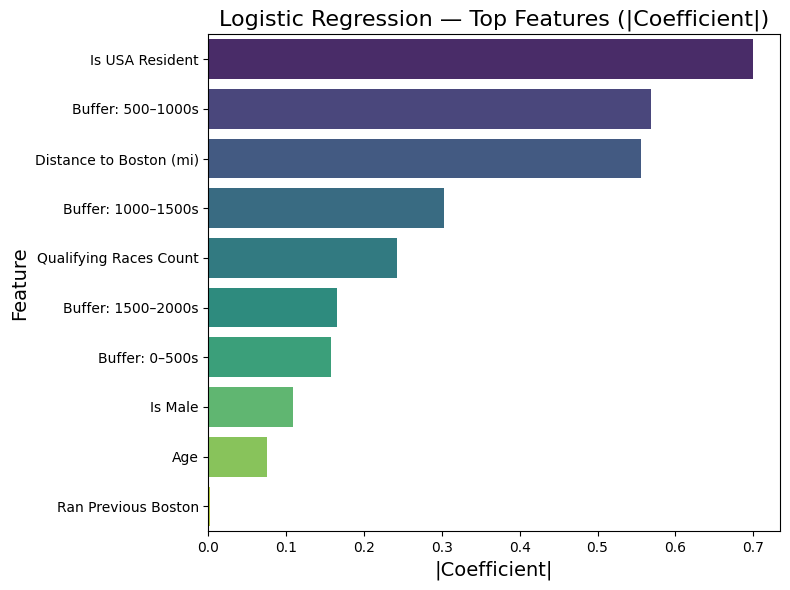


Top Gradient Boosting importances:
          feature_label  importance
        Is USA Resident    0.487341
Distance to Boston (mi)    0.205790
      Buffer: 500–1000s    0.151560
 Qualifying Races Count    0.057788
                    Age    0.031791
    Ran Previous Boston    0.024896
     Buffer: 1000–1500s    0.022907
         Buffer: 0–500s    0.012061
                Is Male    0.003075
     Buffer: 1500–2000s    0.002790


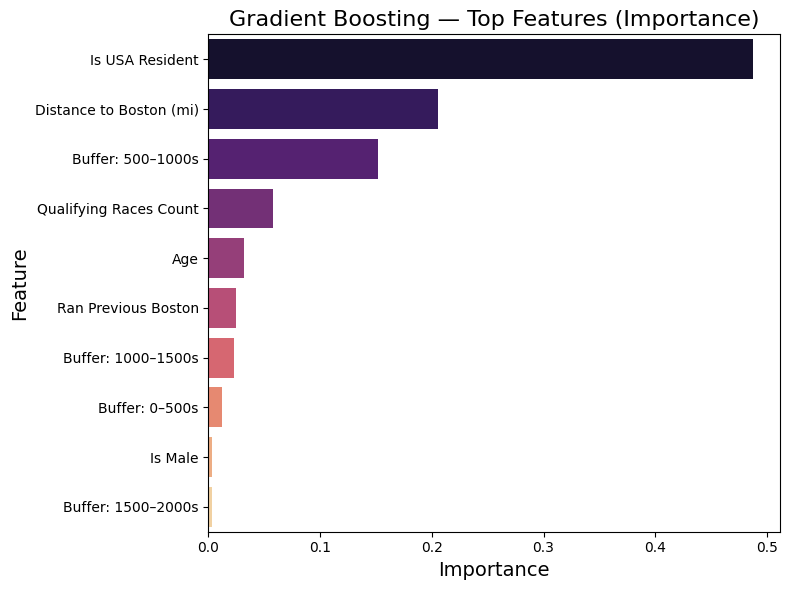

In [ ]:
# ======================================================
# 17. VARIABLE IMPORTANCES (Logit Coeffs & GB Importances)
# ======================================================

# Extract feature names from training feature matrix
feature_names = list(X25.columns)

# Human-readable labels for presentation
presentable_feature_names = {
    "Age": "Age",
    "is_male": "Is Male",
    "is_usa": "Is USA Resident",
    "Count": "Qualifying Races Count",
    "Ran_Previous_Boston": "Ran Previous Boston",
    "dist_to_boston_mi": "Distance to Boston (mi)",
    "buffer_0_500": "Buffer: 0–500s",
    "buffer_500_1000": "Buffer: 500–1000s",
    "buffer_1000_1500": "Buffer: 1000–1500s",
    "buffer_1500_2000": "Buffer: 1500–2000s",
}

# ----------------------------
# Logistic Regression importance (coefficients)
# ----------------------------

# Extract coefficients from trained logistic regression (scaled feature space)
logit_coef = logit_model.coef_[0]

# Build dataframe of coefficients
logit_importance = pd.DataFrame({
    "feature": feature_names,
    "coef": logit_coef,
})

# Compute absolute coefficient values for ranking
logit_importance["abs_coef"] = logit_importance["coef"].abs()

# Map raw feature names to readable labels
logit_importance["feature_label"] = logit_importance["feature"].map(presentable_feature_names)

# Sort features by absolute coefficient magnitude
logit_importance = logit_importance.sort_values("abs_coef", ascending=False)

# Print top coefficients
print("\nTop Logistic Regression coefficients (by |coef|):")
print(
    logit_importance[["feature_label", "coef"]]
    .head(15)
    .to_string(index=False)
)

# Plot top logistic regression coefficients
plt.figure(figsize=(8, 6))
sns.barplot(
    data=logit_importance.head(15),
    x="abs_coef",
    y="feature_label",
    palette="viridis",
    hue="feature_label",
    legend=False,
)
plt.title("Logistic Regression — Top Features (|Coefficient|)")
plt.xlabel("|Coefficient|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ----------------------------
# Gradient Boosting importance
# ----------------------------

# Extract trained gradient boosting model
gb_model = gb_results["model"]

# Build dataframe of feature importances
gb_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": gb_model.feature_importances_,
})

# Map raw feature names to readable labels
gb_importance["feature_label"] = gb_importance["feature"].map(presentable_feature_names)

# Sort features by importance
gb_importance = gb_importance.sort_values("importance", ascending=False)

# Print top gradient boosting importances
print("\nTop Gradient Boosting importances:")
print(
    gb_importance[["feature_label", "importance"]]
    .head(15)
    .to_string(index=False)
)

# Plot top gradient boosting feature importances
plt.figure(figsize=(8, 6))
sns.barplot(
    data=gb_importance.head(15),
    x="importance",
    y="feature_label",
    palette="magma",
    hue="feature_label",
    legend=False,
)
plt.title("Gradient Boosting — Top Features (Importance)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


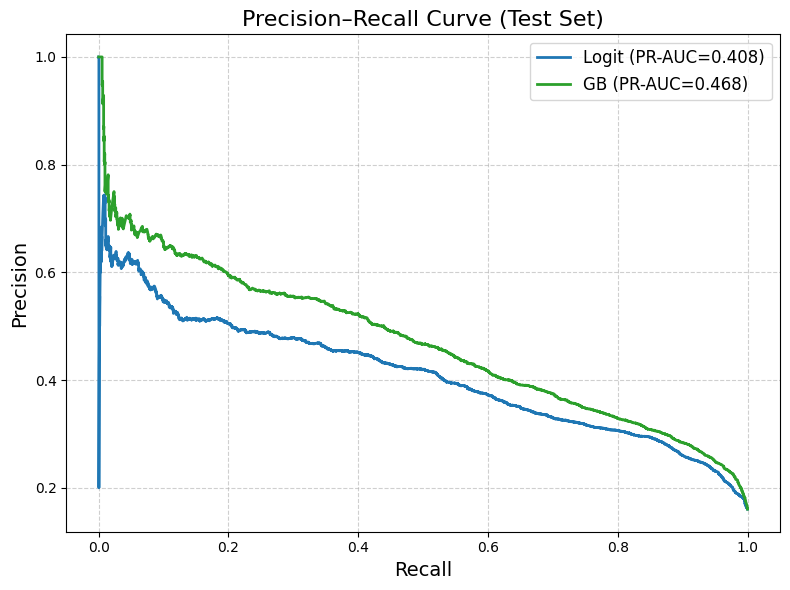

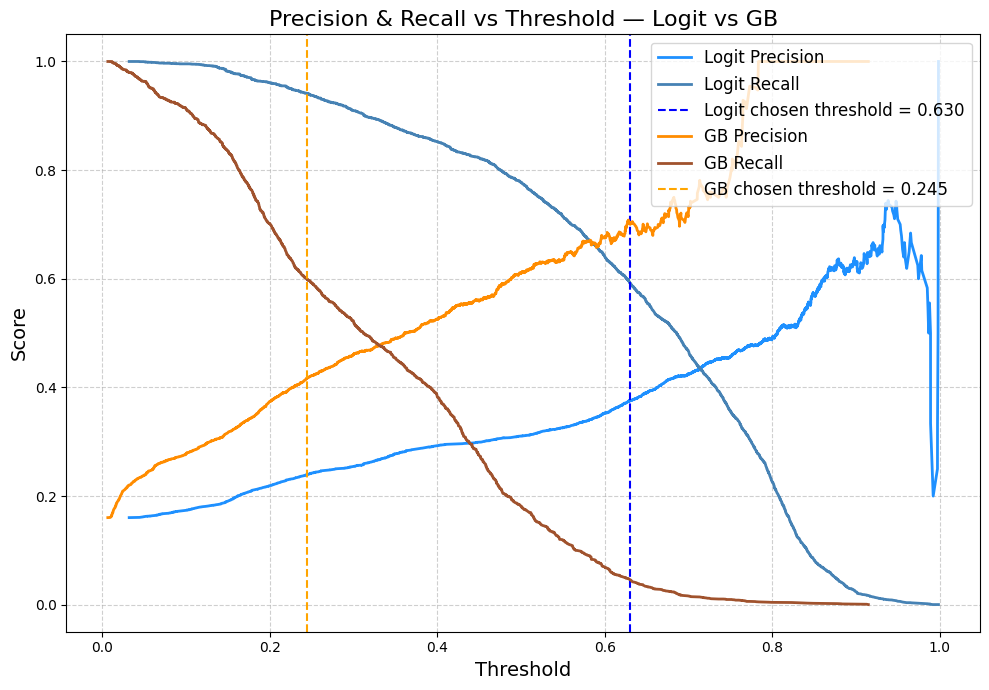

In [ ]:
# ======================================================
# 18. PRECISION–RECALL CURVES & THRESHOLD TRADEOFFS
# ======================================================

# ----------------------------
# Precision–Recall curves (TEST set)
# ----------------------------

# Compute PR curve and PR-AUC for logistic regression
prec_logit, rec_logit, thr_logit = precision_recall_curve(y_test, test_proba_logit)
pr_auc_logit = auc(rec_logit, prec_logit)

# Compute PR curve and PR-AUC for gradient boosting
prec_gb, rec_gb, thr_gb = precision_recall_curve(y_test, gb_test_proba)
pr_auc_gb = auc(rec_gb, prec_gb)

# Plot PR curves
plt.figure(figsize=(8, 6))
plt.plot(
    rec_logit,
    prec_logit,
    lw=2,
    label=f"Logit (PR-AUC={pr_auc_logit:.3f})",
)
plt.plot(rec_gb, rec_gb * 0 + np.nan, alpha=0)  # placeholder for consistent styling
plt.plot(
    rec_gb,
    prec_gb,
    lw=2,
    label=f"GB (PR-AUC={pr_auc_gb:.3f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Precision & Recall vs Threshold
# ----------------------------

# Align threshold arrays with precision/recall lengths
logit_thr_plot = thr_logit
logit_prec_plot = prec_logit[:-1]
logit_rec_plot = rec_logit[:-1]

gb_thr_plot = thr_gb
gb_prec_plot = prec_gb[:-1]
gb_rec_plot = rec_gb[:-1]

# Plot precision and recall as functions of threshold
plt.figure(figsize=(10, 7))

# Logistic regression curves
plt.plot(
    logit_thr_plot,
    logit_prec_plot,
    lw=2,
    label="Logit Precision",
    color="dodgerblue",
)
plt.plot(
    logit_thr_plot,
    logit_rec_plot,
    lw=2,
    label="Logit Recall",
    color="steelblue",
)

# Mark chosen logistic regression threshold
plt.axvline(
    logit_results["threshold"],
    color="blue",
    linestyle="--",
    label=f"Logit chosen threshold = {logit_results['threshold']:.3f}",
)

# Gradient boosting curves
plt.plot(
    gb_thr_plot,
    gb_prec_plot,
    lw=2,
    label="GB Precision",
    color="darkorange",
)
plt.plot(
    gb_thr_plot,
    gb_rec_plot,
    lw=2,
    label="GB Recall",
    color="sienna",
)

# Mark chosen gradient boosting threshold
plt.axvline(
    gb_results["best_threshold"],
    color="orange",
    linestyle="--",
    label=f"GB chosen threshold = {gb_results['best_threshold']:.3f}",
)

# Final plot formatting
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold — Logit vs GB")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ======================================================
# 19. MICRO CUTOFF MODEL — GENERIC FUNCTION + BOOTSTRAP CIs
# ======================================================

def micro_cutoff_from_probabilities(
    df_base,
    proba,
    threshold,
    buffer_col="max_buffer",
    bibs_accepted=24069,
    applicants_total=36406,
    in_dataset_applicants=None,
):
    """
    MICRO cutoff model:
      1) Convert probabilities to binary applicant predictions
      2) Restrict to predicted applicants only
      3) Scale bib supply using true acceptance rate
      4) Rank runners by fastest buffer (smallest is fastest)
      5) Cutoff equals buffer at scaled bib index

    Returns
    -------
    cutoff_seconds, cutoff_minutes, predicted_applicants_df
    """
    # Copy base dataframe to avoid mutation
    df = df_base.copy()

    # Attach predicted probabilities and binary application decision
    df["predicted_probability"] = proba
    df["predicted_apply"] = (proba >= threshold).astype(int)

    # Keep only predicted applicants
    predicted_applicants = df[df["predicted_apply"] == 1].copy()

    # Default to number of predicted applicants if not provided
    if in_dataset_applicants is None:
        in_dataset_applicants = len(predicted_applicants)

    # Compute true acceptance rate from macro totals
    true_accept_rate = bibs_accepted / applicants_total

    # Scale bib count to in-dataset applicant pool
    scaled_bibs = int(in_dataset_applicants * true_accept_rate)

    # Sort applicants by buffer (smaller buffer = faster runner)
    predicted_applicants = predicted_applicants.sort_values(
        buffer_col,
        ascending=True,
    )

    # Ensure bib count does not exceed applicant count
    effective_bibs = min(scaled_bibs, len(predicted_applicants))

    # Identify cutoff runner and cutoff buffer
    if effective_bibs > 0:
        cutoff_runner = predicted_applicants.iloc[effective_bibs - 1]
        cutoff_seconds = cutoff_runner[buffer_col]
        cutoff_minutes = cutoff_seconds / 60.0
    else:
        cutoff_runner = None
        cutoff_seconds = np.nan
        cutoff_minutes = np.nan

    return cutoff_seconds, cutoff_minutes, predicted_applicants


def bootstrap_micro_cutoff_ci(
    df_base,
    proba,
    threshold,
    buffer_col,
    bibs_accepted,
    applicants_total,
    in_dataset_applicants,
    n_boot=500,
    alpha=0.05,
):
    """
    Bootstrap the MICRO cutoff by resampling rows from df_base
    and recomputing the cutoff for each bootstrap draw.
    """
    # Copy base dataframe and attach probabilities
    df = df_base.copy()
    df["predicted_probability"] = proba
    df["predicted_apply"] = (proba >= threshold).astype(int)

    # Container for bootstrapped cutoff values (minutes)
    cutoff_minutes_list = []

    # Number of observations
    n = len(df)

    # Bootstrap resampling loop
    for _ in range(n_boot):
        # Sample rows with replacement
        idx = rng.integers(0, n, n)
        df_b = df.iloc[idx].copy()

        # Recompute cutoff using bootstrapped sample
        cutoff_sec_b, cutoff_min_b, _ = micro_cutoff_from_probabilities(
            df_base=df_b,
            proba=df_b["predicted_probability"].values,
            threshold=threshold,
            buffer_col=buffer_col,
            bibs_accepted=bibs_accepted,
            applicants_total=applicants_total,
            in_dataset_applicants=in_dataset_applicants,
        )

        # Store bootstrap cutoff
        cutoff_minutes_list.append(cutoff_min_b)

    # Convert to array for percentile calculations
    cutoff_minutes_arr = np.array(cutoff_minutes_list)

    # Compute percentile-based confidence interval
    lo = np.nanpercentile(cutoff_minutes_arr, 100 * (alpha / 2))
    hi = np.nanpercentile(cutoff_minutes_arr, 100 * (1 - alpha / 2))

    # Return median cutoff and confidence interval
    return np.nanmedian(cutoff_minutes_arr), (lo, hi)


In [ ]:
# ======================================================
# 20. MICRO CUTOFF — 2025 USING LOGIT APPLICANTS
# ======================================================

# Print section header
print("\n=== MICRO CUTOFF MODEL — 2025 (Logit applicants) ===")

# ----------------------------
# Prepare full 2025 dataset
# ----------------------------

# Build features for all 2025 qualifiers
X25_all, y25_all, df25_all = make_features(df25, is_2025=True)

# Scale features using scaler fit on training data
X25_all_scaled = scaler.transform(X25_all)

# Predict application probabilities for all 2025 qualifiers
proba_25_all_logit = logit_model.predict_proba(X25_all_scaled)[:, 1]

# ----------------------------
# Ground-truth macro inputs
# ----------------------------

# Actual number of accepted runners in 2025
actual_bibs_2025 = 24069

# Actual number of applicants in 2025
actual_applied_2025 = 36406

# Number of applicants represented in the dataset
in_dataset_applied_2025 = df25_all["Applied"].sum()

# ----------------------------
# Micro cutoff estimation
# ----------------------------

# Compute micro-level cutoff using predicted applicants
cutoff_sec_25, cutoff_min_25, predicted_apps_25 = micro_cutoff_from_probabilities(
    df_base=df25_all,
    proba=proba_25_all_logit,
    threshold=logit_results["threshold"],
    buffer_col="max_buffer",
    bibs_accepted=actual_bibs_2025,
    applicants_total=actual_applied_2025,
    in_dataset_applicants=in_dataset_applied_2025,
)

# Print point estimate of cutoff
print(f"Predicted 2025 cutoff (micro, logit): {cutoff_min_25:.2f} min faster than BQ")

# ----------------------------
# Bootstrap confidence interval
# ----------------------------

# Compute bootstrap CI for micro cutoff
median_25, ci_25 = bootstrap_micro_cutoff_ci(
    df_base=df25_all,
    proba=proba_25_all_logit,
    threshold=logit_results["threshold"],
    buffer_col="max_buffer",
    bibs_accepted=actual_bibs_2025,
    applicants_total=actual_applied_2025,
    in_dataset_applicants=in_dataset_applied_2025,
    n_boot=500,
    alpha=0.05,   # 95% confidence interval
)

# Print bootstrap confidence interval
print(
    "Bootstrap 95% CI (micro, logit, 2025 cutoff): "
    f"[{ci_25[0]:.2f}, {ci_25[1]:.2f}] min"
)



=== MICRO CUTOFF MODEL — 2025 (Logit applicants) ===
Predicted 2025 cutoff (micro, logit): 11.37 min faster than BQ
Bootstrap 95% CI (micro, logit, 2025 cutoff): [11.25, 11.50] min


In [ ]:
# ======================================================
# 21. MICRO CUTOFF — 2026 USING LOGIT & GB APPLICANTS
# ======================================================

# Print section header
print("\n=== MICRO CUTOFF MODEL — 2026 (Logit & GB applicants) ===")

# ----------------------------
# Ground-truth macro inputs
# ----------------------------

# Actual number of accepted runners in 2026
actual_bibs_2026 = 24362

# Actual number of applicants in 2026
actual_applied_2026 = 33267

# Number of qualifiers represented in the dataset (not actual applicants)
in_dataset_qualifiers_2026 = len(df26_clean)

# ----------------------------
# Logistic regression micro cutoff
# ----------------------------

# Compute micro cutoff using logistic regression applicant predictions
cutoff_sec_26_logit, cutoff_min_26_logit, predicted_apps_26_logit = (
    micro_cutoff_from_probabilities(
        df_base=df26_clean,
        proba=proba_logit,
        threshold=logit_results["threshold"],
        buffer_col="max_buffer",
        bibs_accepted=actual_bibs_2026,
        applicants_total=actual_applied_2026,
        in_dataset_applicants=in_dataset_qualifiers_2026,
    )
)

# Bootstrap confidence interval for logit micro cutoff
median_26_logit, ci_26_logit = bootstrap_micro_cutoff_ci(
    df_base=df26_clean,
    proba=proba_logit,
    threshold=logit_results["threshold"],
    buffer_col="max_buffer",
    bibs_accepted=actual_bibs_2026,
    applicants_total=actual_applied_2026,
    in_dataset_applicants=in_dataset_qualifiers_2026,
    n_boot=500,
    alpha=0.05,   # 95% confidence interval
)

# Print logit micro cutoff results
print(f"2026 micro cutoff (logit): {cutoff_min_26_logit:.2f} min")
print(
    f"Bootstrap 95% CI (logit micro): "
    f"[{ci_26_logit[0]:.2f}, {ci_26_logit[1]:.2f}] min"
)

# ----------------------------
# Gradient boosting micro cutoff
# ----------------------------

# Compute micro cutoff using gradient boosting applicant predictions
cutoff_sec_26_gb, cutoff_min_26_gb, predicted_apps_26_gb = (
    micro_cutoff_from_probabilities(
        df_base=df26_clean,
        proba=proba_gb,
        threshold=gb_results["best_threshold"],
        buffer_col="max_buffer",
        bibs_accepted=actual_bibs_2026,
        applicants_total=actual_applied_2026,
        in_dataset_applicants=in_dataset_qualifiers_2026,
    )
)

# Bootstrap confidence interval for GB micro cutoff
median_26_gb, ci_26_gb = bootstrap_micro_cutoff_ci(
    df_base=df26_clean,
    proba=proba_gb,
    threshold=gb_results["best_threshold"],
    buffer_col="max_buffer",
    bibs_accepted=actual_bibs_2026,
    applicants_total=actual_applied_2026,
    in_dataset_applicants=in_dataset_qualifiers_2026,
    n_boot=500,
    alpha=0.05,   # 95% confidence interval
)

# Print GB micro cutoff results
print(f"2026 micro cutoff (GB): {cutoff_min_26_gb:.2f} min")
print(
    f"Bootstrap 95% CI (GB micro): "
    f"[{ci_26_gb[0]:.2f}, {ci_26_gb[1]:.2f}] min"
)

# ----------------------------
# Actual 2026 cutoff for comparison
# ----------------------------

# Official 2026 cutoff (minutes faster than BQ)
actual_cutoff_2026 = 4 + 34 / 60

# Print actual cutoff
print(f"\nActual 2026 cutoff: {actual_cutoff_2026:.2f} min")



=== MICRO CUTOFF MODEL — 2026 (Logit & GB applicants) ===
2026 micro cutoff (logit): 290.00 min
Bootstrap 95% CI (logit micro): [245.00, 290.00] min
2026 micro cutoff (GB): 290.00 min
Bootstrap 95% CI (GB micro): [245.00, 290.00] min

Actual 2026 cutoff: 4.57 min


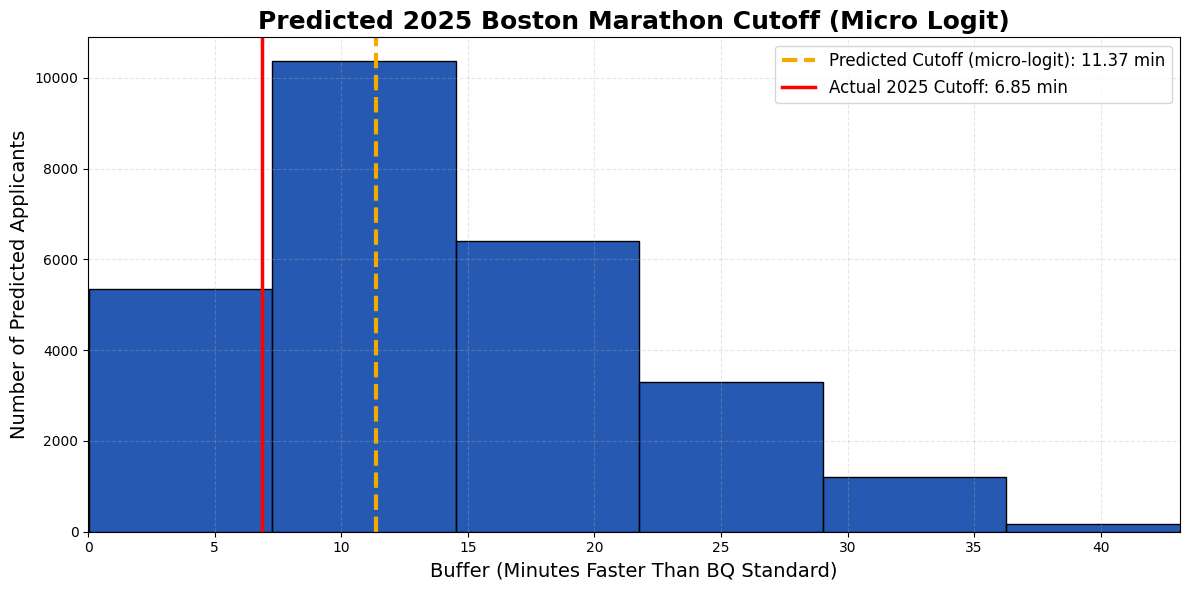

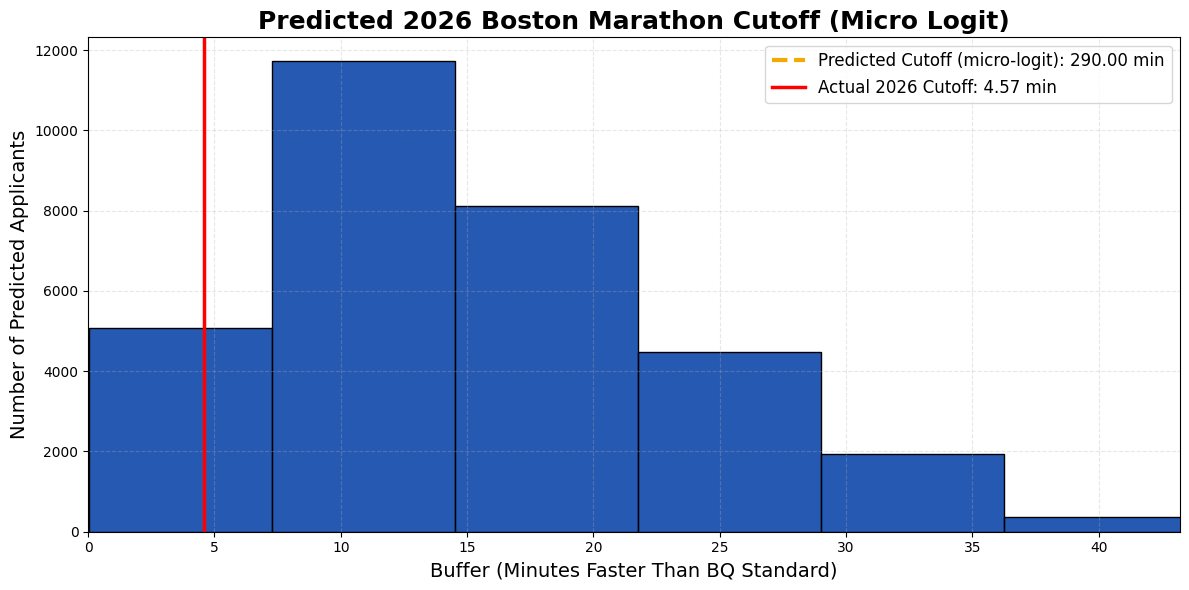

In [ ]:
# ======================================================
# 22. MICRO CUTOFF — PLOTS FOR 2025 & 2026
# ======================================================

# ----------------------------
# 2025 Micro Cutoff Plot
# ----------------------------

# Copy predicted 2025 applicants and convert buffer to minutes
plot_df_25 = predicted_apps_25.copy()
plot_df_25["buffer_minutes"] = plot_df_25["max_buffer"] / 60.0

# Actual 2025 cutoff (minutes faster than BQ)
actual_cutoff_2025 = 6 + 51 / 60

# Plot histogram of buffer distribution
plt.figure(figsize=(12, 6))
sns.histplot(
    plot_df_25["buffer_minutes"],
    bins=40,
    kde=False,
    color="#003DA5",
    edgecolor="black",
    alpha=0.85,
)

# Predicted micro cutoff line
plt.axvline(
    cutoff_min_25,
    linestyle="--",
    color="#F2A900",
    linewidth=3,
    label=f"Predicted Cutoff (micro-logit): {cutoff_min_25:.2f} min",
)

# Actual cutoff line
plt.axvline(
    actual_cutoff_2025,
    linestyle="-",
    color="red",
    linewidth=2.5,
    label=f"Actual 2025 Cutoff: {actual_cutoff_2025:.2f} min",
)

# Plot formatting
plt.title(
    "Predicted 2025 Boston Marathon Cutoff (Micro Logit)",
    fontsize=18,
    weight="bold",
)
plt.xlabel("Buffer (Minutes Faster Than BQ Standard)", fontsize=14)
plt.ylabel("Number of Predicted Applicants", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle="--")

# Limit x-axis to reduce extreme tail influence
right_limit_25 = plot_df_25["buffer_minutes"].quantile(0.99)
plt.xlim(0, right_limit_25)

plt.tight_layout()
plt.show()

# ----------------------------
# 2026 Micro Cutoff Plot (Logit)
# ----------------------------

# Copy predicted 2026 applicants and convert buffer to minutes
plot_df_26 = predicted_apps_26_logit.copy()
plot_df_26["buffer_minutes"] = plot_df_26["max_buffer"] / 60.0

# Plot histogram of buffer distribution
plt.figure(figsize=(12, 6))
sns.histplot(
    plot_df_26["buffer_minutes"],
    bins=40,
    kde=False,
    color="#003DA5",
    edgecolor="black",
    alpha=0.85,
)

# Predicted micro cutoff line
plt.axvline(
    cutoff_min_26_logit,
    linestyle="--",
    color="#F2A900",
    linewidth=3,
    label=f"Predicted Cutoff (micro-logit): {cutoff_min_26_logit:.2f} min",
)

# Actual cutoff line
plt.axvline(
    actual_cutoff_2026,
    linestyle="-",
    color="red",
    linewidth=2.5,
    label=f"Actual 2026 Cutoff: {actual_cutoff_2026:.2f} min",
)

# Plot formatting
plt.title(
    "Predicted 2026 Boston Marathon Cutoff (Micro Logit)",
    fontsize=18,
    weight="bold",
)
plt.xlabel("Buffer (Minutes Faster Than BQ Standard)", fontsize=14)
plt.ylabel("Number of Predicted Applicants", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle="--")

# Limit x-axis to reduce extreme tail influence
right_limit_26 = plot_df_26["buffer_minutes"].quantile(0.99)
plt.xlim(0, right_limit_26)

plt.tight_layout()
plt.show()



=== MACRO MODEL TRAINING RESULTS (OLS cutoff ~ pressure) ===
                            OLS Regression Results                            
Dep. Variable:             Cutoff_min   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     75.13
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.64e-06
Time:                        19:07:33   Log-Likelihood:                -18.640
No. Observations:                  14   AIC:                             41.28
Df Residuals:                      12   BIC:                             42.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

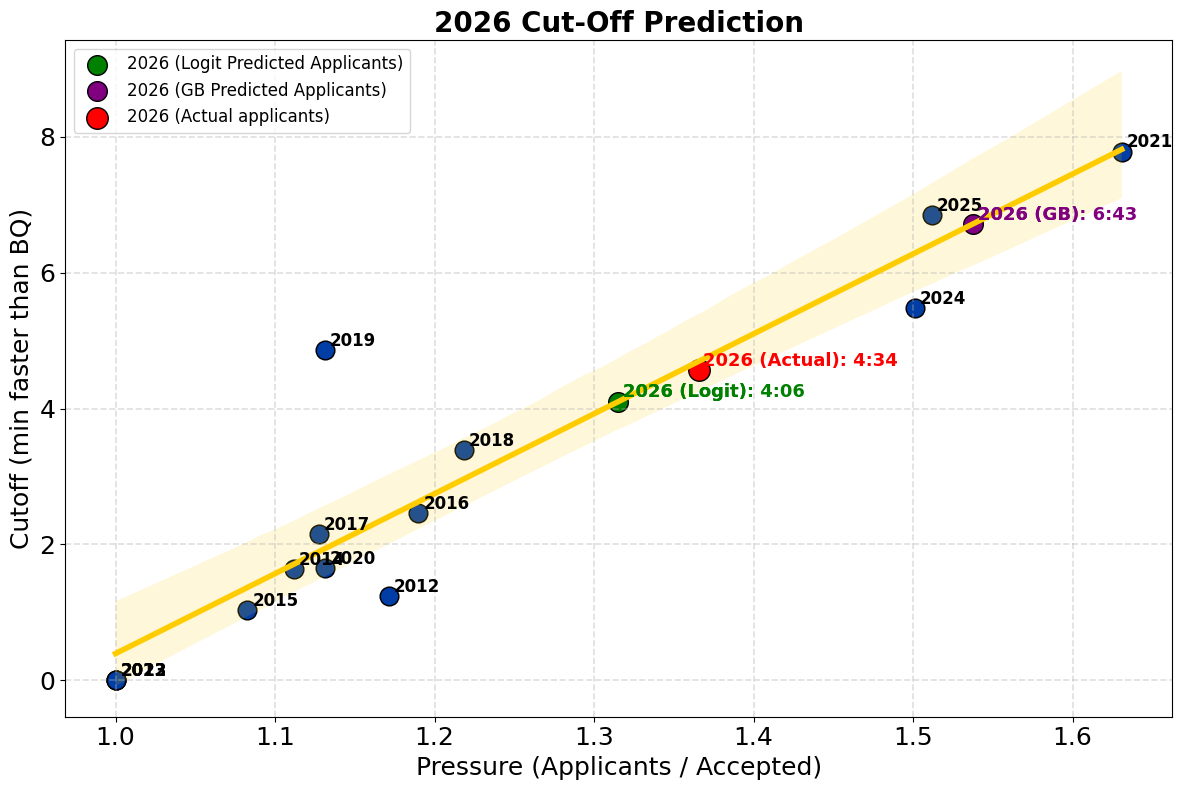

In [ ]:
# ======================================================
# 23. MACRO CUTOFF MODEL — OLS: Cutoff_min ~ Pressure
# ======================================================

# Recreate macro-level dataframe
df_macro = df_hist.copy()

# Define pressure as applicants divided by accepted bibs
df_macro["pressure"] = df_macro["Applicants"] / df_macro["Accepted"]

# Split macro data: train on 2012–2025, test on 2026
train_macro = df_macro[df_macro["Year"] < 2026].copy()
test_macro = df_macro[df_macro["Year"] == 2026].copy()

# Build design matrix with intercept
X_train_macro = sm.add_constant(train_macro["pressure"])
y_train_macro = train_macro["Cutoff_min"]

# Fit OLS regression: cutoff ~ pressure
macro_ols_model = sm.OLS(y_train_macro, X_train_macro).fit()

# Print regression summary
print("\n=== MACRO MODEL TRAINING RESULTS (OLS cutoff ~ pressure) ===")
print(macro_ols_model.summary())

# ------------------------------------------------------
# Helper: predict cutoff + confidence intervals
# ------------------------------------------------------
def macro_cutoff_with_ci(pred_applicants, accepted_bibs, model, alpha=0.05):
    """
    Given predicted applicants and accepted bibs:
      • compute pressure
      • predict cutoff
      • return mean CI and prediction interval
    """
    # Compute pressure for new observation
    pressure = pred_applicants / accepted_bibs

    # Build design matrix for prediction
    X_new = pd.DataFrame({"const": [1.0], "pressure": [pressure]})

    # Get prediction results with intervals
    res = model.get_prediction(X_new)
    sf = res.summary_frame(alpha=alpha)

    # Extract predicted cutoff and intervals
    pred_cutoff = float(sf["mean"].iloc[0])
    mean_ci = (
        float(sf["mean_ci_lower"].iloc[0]),
        float(sf["mean_ci_upper"].iloc[0]),
    )
    obs_ci = (
        float(sf["obs_ci_lower"].iloc[0]),
        float(sf["obs_ci_upper"].iloc[0]),
    )

    return pressure, pred_cutoff, mean_ci, obs_ci

# Ground-truth 2026 values
accepted_2026 = 24362
true_cutoff_2026 = actual_cutoff_2026

# ------------------------------------------------------
# MACRO prediction using LOGIT applicant count
# ------------------------------------------------------

# Predict cutoff using logit-predicted applicants
pressure_logit_macro, pred_cutoff_logit_macro, mean_ci_logit_macro, obs_ci_logit_macro = (
    macro_cutoff_with_ci(
        logit_binary,
        accepted_2026,
        macro_ols_model,
        alpha=0.05,  # 95% CI
    )
)

# Print logit-based macro results
print("\n=== MACRO MODEL USING LOGIT PREDICTED APPLICANTS ===")
print(f"Predicted applicants (logit): {logit_binary:,}")
print(f"Accepted (BAA):              {accepted_2026:,}")
print(f"Pressure (logit macro):      {pressure_logit_macro:.3f}")
print(f"Predicted 2026 cutoff:       {pred_cutoff_logit_macro:.3f} min")
print(f"95% CI (mean cutoff):        [{mean_ci_logit_macro[0]:.3f}, {mean_ci_logit_macro[1]:.3f}]")
print(f"95% prediction interval:     [{obs_ci_logit_macro[0]:.3f}, {obs_ci_logit_macro[1]:.3f}]")

# Compute errors vs actual cutoff
abs_err_logit_macro = abs(pred_cutoff_logit_macro - true_cutoff_2026)
pct_err_logit_macro = (
    (pred_cutoff_logit_macro - true_cutoff_2026)
    / true_cutoff_2026 * 100
)
print(f"Absolute error vs true:      {abs_err_logit_macro:.3f} min")
print(f"Percent error vs true:       {pct_err_logit_macro:.2f}%")

# ------------------------------------------------------
# MACRO prediction using GB applicant count
# ------------------------------------------------------

# Predict cutoff using GB-predicted applicants
pressure_gb_macro, pred_cutoff_gb_macro, mean_ci_gb_macro, obs_ci_gb_macro = (
    macro_cutoff_with_ci(
        gb_binary,
        accepted_2026,
        macro_ols_model,
        alpha=0.05,  # 95% CI
    )
)

# Print GB-based macro results
print("\n=== MACRO MODEL USING GB PREDICTED APPLICANTS ===")
print(f"Predicted applicants (GB):   {gb_binary:,}")
print(f"Accepted (BAA):              {accepted_2026:,}")
print(f"Pressure (GB macro):         {pressure_gb_macro:.3f}")
print(f"Predicted 2026 cutoff:       {pred_cutoff_gb_macro:.3f} min")
print(f"95% CI (mean cutoff):        [{mean_ci_gb_macro[0]:.3f}, {mean_ci_gb_macro[1]:.3f}]")
print(f"95% prediction interval:     [{obs_ci_gb_macro[0]:.3f}, {obs_ci_gb_macro[1]:.3f}]")

# Compute errors vs actual cutoff
abs_err_gb_macro = abs(pred_cutoff_gb_macro - true_cutoff_2026)
pct_err_gb_macro = (
    (pred_cutoff_gb_macro - true_cutoff_2026)
    / true_cutoff_2026 * 100
)
print(f"Absolute error vs true:      {abs_err_gb_macro:.3f} min")
print(f"Percent error vs true:       {pct_err_gb_macro:.2f}%")

# ------------------------------------------------------
# Visualization: cutoff vs pressure with 2026 points
# ------------------------------------------------------

# Copy training data for plotting
train_plot = train_macro.copy()

# Scatter plot of historical years
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=train_plot,
    x="pressure",
    y="Cutoff_min",
    s=180,
    color="#003DA5",
    edgecolor="black",
)

# Regression line from macro model
sns.regplot(
    data=train_plot,
    x="pressure",
    y="Cutoff_min",
    scatter=False,
    color="#FFCC00",
    line_kws={"linewidth": 4},
)

# Annotate historical years
for _, row in train_plot.iterrows():
    plt.text(
        row["pressure"] + 0.003,
        row["Cutoff_min"] + 0.06,
        str(int(row["Year"])),
        fontsize=12,
        weight="bold",
    )

# Plot predicted 2026 macro points
plt.scatter(
    pressure_logit_macro,
    pred_cutoff_logit_macro,
    s=200,
    color="green",
    edgecolor="black",
    label="2026 (Logit Predicted Applicants)",
)
plt.scatter(
    pressure_gb_macro,
    pred_cutoff_gb_macro,
    s=200,
    color="purple",
    edgecolor="black",
    label="2026 (GB Predicted Applicants)",
)

# Plot actual 2026 point
pressure_actual_2026 = float(test_macro["pressure"].iloc[0])
plt.scatter(
    pressure_actual_2026,
    true_cutoff_2026,
    s=240,
    color="red",
    edgecolor="black",
    label="2026 (Actual applicants)",
)

# Annotate 2026 points
plt.text(
    pressure_logit_macro + 0.003,
    pred_cutoff_logit_macro + 0.06,
    "2026 (Logit)",
    fontsize=13,
    weight="bold",
    color="green",
)
plt.text(
    pressure_gb_macro + 0.003,
    pred_cutoff_gb_macro + 0.06,
    "2026 (GB)",
    fontsize=13,
    weight="bold",
    color="purple",
)
plt.text(
    pressure_actual_2026 + 0.003,
    true_cutoff_2026 + 0.06,
    "2026 (Actual): 4:34",
    fontsize=13,
    weight="bold",
    color="red",
)

# Final plot formatting
plt.title("2026 Cut-Off Prediction", fontsize=20, weight="bold")
plt.xlabel("Pressure (Applicants / Accepted)", fontsize=18)
plt.ylabel("Cutoff (min faster than BQ)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle="--", linewidth=1.2, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ======================================================
# 24. (OPTIONAL) MAJORS-ONLY MODELING BLOCK
# ======================================================

# Define list of World Marathon Majors
MAJORS = [
    "Boston Marathon",
    "New York City Marathon",
    "Chicago Marathon",
    "Berlin Marathon",
    "London Marathon",
    "Tokyo Marathon",
]

# Print section header
print("\n====================================================")
print(" MAJORS-ONLY ANALYSIS (subset of qualifiers) ")
print("====================================================")

# Subset 2025 and 2026 data to majors-only races
df25_majors = df25[df25["Race"].isin(MAJORS)].copy()
df26_majors = df26[df26["Race"].isin(MAJORS)].copy()

# Print sample sizes
print(f"2025 Major Marathon qualifiers: {len(df25_majors):,}")
print(f"2026 Major Marathon qualifiers: {len(df26_majors):,}")

# Build feature matrices for majors-only data
X25m, y25m, df25m_clean = make_features(df25_majors, is_2025=True)
X26m, _, df26m_clean = make_features(df26_majors, is_2025=False)

# Print feature shape and class balance
print("Feature shape (2025 majors):", X25m.shape)
print("Positive rate (2025 majors):", y25m.mean())

# ----------------------------
# Train / Dev / Test split
# ----------------------------

# Split majors-only data into train and temp sets
X_train_m, X_temp_m, y_train_m, y_temp_m = train_test_split(
    X25m,
    y25m,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y25m,
)

# Split temp set into dev and test sets
X_dev_m, X_test_m, y_dev_m, y_test_m = train_test_split(
    X_temp_m,
    y_temp_m,
    test_size=2/3,
    random_state=RANDOM_STATE,
    stratify=y_temp_m,
)

# Print split sizes
print("\nTrain/Dev/Test sizes (majors):")
print(" Train:", len(X_train_m))
print(" Dev:  ", len(X_dev_m))
print(" Test: ", len(X_test_m))

# ----------------------------
# Feature scaling (for logit)
# ----------------------------

# Initialize scaler for majors-only models
scaler_m = StandardScaler()

# Fit scaler on training data and transform all splits
X_train_m_scaled = scaler_m.fit_transform(X_train_m)
X_dev_m_scaled = scaler_m.transform(X_dev_m)
X_test_m_scaled = scaler_m.transform(X_test_m)

# ----------------------------
# Logistic Regression (majors)
# ----------------------------

# Initialize logistic regression model
logit_m = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",
    max_iter=2000,
    random_state=RANDOM_STATE,
)

# Fit model on scaled training data
logit_m.fit(X_train_m_scaled, y_train_m)

# Predict probabilities on dev set
dev_proba_logit_m = logit_m.predict_proba(X_dev_m_scaled)[:, 1]

# Tune threshold on dev set
best_t_logit_m, best_f1_logit_m = tune_threshold_on_dev(
    dev_proba_logit_m,
    y_dev_m,
)

# Predict probabilities and binary outcomes on test set
test_proba_logit_m = logit_m.predict_proba(X_test_m_scaled)[:, 1]
test_pred_logit_m = (test_proba_logit_m >= best_t_logit_m).astype(int)

# Print majors-only logit results
print("\nLOGISTIC REGRESSION (Majors)")
print("--------------------------------------------")
print("Best dev threshold:", round(best_t_logit_m, 3))
print("Test F1:", round(f1_score(y_test_m, test_pred_logit_m), 4))
print("Test Precision:", round(precision_score(y_test_m, test_pred_logit_m), 4))
print("Test Recall:", round(recall_score(y_test_m, test_pred_logit_m), 4))
print("ROC-AUC:", round(roc_auc_score(y_test_m, test_proba_logit_m), 4))

# ----------------------------
# Gradient Boosting (majors)
# ----------------------------

# Initialize gradient boosting model
gb_m = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    random_state=RANDOM_STATE,
)

# Fit model on unscaled features
gb_m.fit(X_train_m, y_train_m)

# Predict probabilities on dev set
dev_proba_gb_m = gb_m.predict_proba(X_dev_m)[:, 1]

# Tune threshold on dev set
best_t_gb_m, best_f1_gb_m = tune_threshold_on_dev(
    dev_proba_gb_m,
    y_dev_m,
)

# Predict probabilities and binary outcomes on test set
test_proba_gb_m = gb_m.predict_proba(X_test_m)[:, 1]
test_pred_gb_m = (test_proba_gb_m >= best_t_gb_m).astype(int)

# Print majors-only GB results
print("\nGRADIENT BOOSTING (Majors)")
print("--------------------------------------------")
print("Best dev threshold:", round(best_t_gb_m, 3))
print("Test F1:", round(f1_score(y_test_m, test_pred_gb_m), 4))
print("Test Precision:", round(precision_score(y_test_m, test_pred_gb_m), 4))
print("Test Recall:", round(recall_score(y_test_m, test_pred_gb_m), 4))
print("ROC-AUC:", round(roc_auc_score(y_test_m, test_proba_gb_m), 4))

# ----------------------------
# Select best majors model by test F1
# ----------------------------

# Compute test F1 for both models
f1_logit_m = f1_score(y_test_m, test_pred_logit_m)
f1_gb_m = f1_score(y_test_m, test_pred_gb_m)

# Choose model with higher F1
if f1_gb_m > f1_logit_m:
    best_model_m = gb_m
    best_threshold_m = best_t_gb_m
    best_scaler_m = None
    best_name_m = "Gradient Boosting"
else:
    best_model_m = logit_m
    best_threshold_m = best_t_logit_m
    best_scaler_m = scaler_m
    best_name_m = "Logistic Regression"

# Print selected best model
print("\n============================================")
print("BEST MODEL FOR MAJORS (by TEST F1):", best_name_m)
print("============================================")

# ----------------------------
# Baseline models (majors-only)
# ----------------------------

# Define baseline classifiers
baselines_m = {
    "Most Frequent": DummyClassifier(strategy="most_frequent"),
    "Stratified Random": DummyClassifier(strategy="stratified", random_state=RANDOM_STATE),
    "Uniform Random": DummyClassifier(strategy="uniform", random_state=RANDOM_STATE),
    "Always Apply (1)": DummyClassifier(strategy="constant", constant=1),
    "Never Apply (0)": DummyClassifier(strategy="constant", constant=0),
}

# Evaluate baselines on majors-only test set
rows_m = []
n_test_m = len(y_test_m)

for name, model in baselines_m.items():
    model.fit(X_train_m, y_train_m)
    y_pred_m = model.predict(X_test_m)
    y_proba_m = (
        model.predict_proba(X_test_m)[:, 1]
        if hasattr(model, "predict_proba")
        else np.full(n_test_m, y_pred_m.mean())
    )
    rows_m.append([
        name,
        accuracy_score(y_test_m, y_pred_m),
        precision_score(y_test_m, y_pred_m, zero_division=0),
        recall_score(y_test_m, y_pred_m, zero_division=0),
        f1_score(y_test_m, y_pred_m, zero_division=0),
        roc_auc_score(y_test_m, y_proba_m),
        y_pred_m.mean(),
        y_pred_m.sum(),
    ])

# Convert baseline results to DataFrame
baseline_majors_df = pd.DataFrame(
    rows_m,
    columns=[
        "Model", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC",
        "Predicted Positive Rate", "Expected Applicants (#)",
    ],
)

# Display baseline comparison table
print("\n==========================================================")
print("BASELINE SCENARIOS — Majors-Only Test Set")
print("==========================================================")
display(baseline_majors_df.sort_values("F1", ascending=False))

# ----------------------------
# Cross-validation for best majors model
# ----------------------------

# Prepare data for CV (scale only if needed)
if best_scaler_m is not None:
    X25m_cv = best_scaler_m.fit_transform(X25m)
else:
    X25m_cv = X25m

# Run 5-fold cross-validation on full majors-only data
cv_scores_m = cross_val_score(
    best_model_m,
    X25m_cv,
    y25m,
    scoring="f1",
    cv=5,
)

# Print CV results
print("\n==========================================================")
print("CROSS-VALIDATION (5-Fold) — Majors-Only, best model")
print("==========================================================")
print("CV F1 scores:", cv_scores_m)
print("Mean F1:", cv_scores_m.mean())
print("Std:", cv_scores_m.std())



 MAJORS-ONLY ANALYSIS (subset of qualifiers) 
2025 Major Marathon qualifiers: 37,958
2026 Major Marathon qualifiers: 42,847
Feature shape (2025 majors): (37958, 10)
Positive rate (2025 majors): 0.15111438958849255

Train/Dev/Test sizes (majors):
 Train: 26570
 Dev:   3796
 Test:  7592

LOGISTIC REGRESSION (Majors)
--------------------------------------------
Best dev threshold: 0.55
Test F1: 0.4458
Test Precision: 0.3304
Test Recall: 0.6853
ROC-AUC: 0.7879

GRADIENT BOOSTING (Majors)
--------------------------------------------
Best dev threshold: 0.275
Test F1: 0.4862
Test Precision: 0.4447
Test Recall: 0.5362
ROC-AUC: 0.8066

BEST MODEL FOR MAJORS (by TEST F1): Gradient Boosting

BASELINE SCENARIOS — Majors-Only Test Set


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,Predicted Positive Rate,Expected Applicants (#)
3,Always Apply (1),0.151080,0.151080,1.000000,0.262501,0.500000,1.000000,7592
2,Uniform Random,0.502898,0.152237,0.501308,0.233550,0.500000,0.497497,3777
1,Stratified Random,0.748288,0.160746,0.157803,0.159261,0.505589,0.148314,1126
0,Most Frequent,0.848920,0.000000,0.000000,0.000000,0.500000,0.000000,0
4,Never Apply (0),0.848920,0.000000,0.000000,0.000000,0.500000,0.000000,0



CROSS-VALIDATION (5-Fold) — Majors-Only, best model
CV F1 scores: [0.00174216 0.24484182 0.45943775 0.12519084 0.13354037]
Mean F1: 0.1929505878658212
Std: 0.15387639686687277


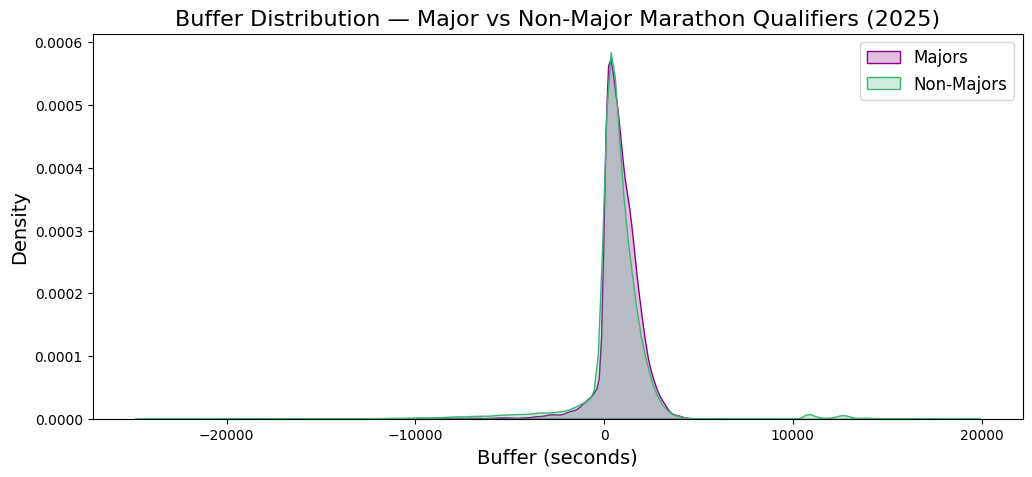

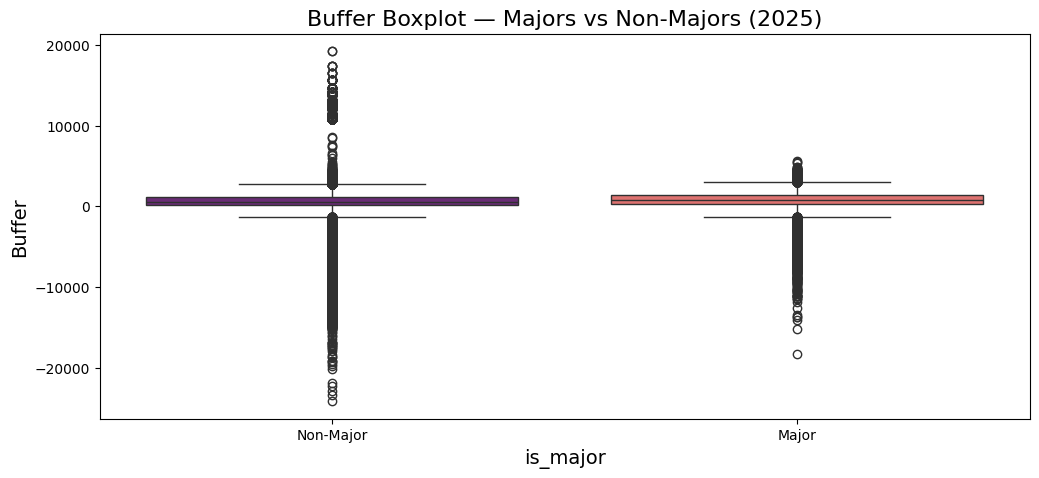

In [ ]:
# ======================================================
# 25. DISTRIBUTION PLOTS — Majors vs Non-Majors (2025)
# ======================================================

# Create indicator for whether race is a World Marathon Major
df25["is_major"] = df25["Race"].isin(MAJORS)

# Split 2025 data into majors and non-majors
df25_maj = df25[df25["is_major"] == True]
df25_non = df25[df25["is_major"] == False]

# ----------------------------
# Kernel density plots
# ----------------------------

# Plot buffer distributions for majors vs non-majors
plt.figure(figsize=(12, 5))
sns.kdeplot(
    df25_maj["Buffer"],
    label="Majors",
    fill=True,
    color="darkmagenta",
)
sns.kdeplot(
    df25_non["Buffer"],
    label="Non-Majors",
    fill=True,
    color="mediumseagreen",
)
plt.title("Buffer Distribution — Major vs Non-Major Marathon Qualifiers (2025)")
plt.xlabel("Buffer (seconds)")
plt.legend()
plt.show()

# ----------------------------
# Boxplot comparison
# ----------------------------

# Plot boxplots comparing buffer distributions
plt.figure(figsize=(12, 5))
sns.boxplot(
    x=df25["is_major"],
    y=df25["Buffer"],
    palette="magma",
    hue=df25["is_major"],
    legend=False,
)
plt.xticks([0, 1], ["Non-Major", "Major"])
plt.title("Buffer Boxplot — Majors vs Non-Majors (2025)")
plt.show()


In [ ]:
# ======================================================
# 26. DESCRIPTIVE STATISTICS HELPER
# ======================================================

def analyze_dataframe_statistics(df, df_name):
    """
    Print high-level descriptive stats for a qualifiers dataframe.
    """

    # Section header
    print("\n=======================================================")
    print(f"STATISTICS FOR: {df_name}")
    print("=======================================================")

    # Dataset size
    print(f"Dataset Size: {len(df):,}")

    # ----------------------------
    # Gender distribution
    # ----------------------------
    if "Gender" in df.columns:
        # Compute gender shares
        gender_counts = df["Gender"].value_counts(normalize=True)
        male_pct = gender_counts.get(1, 0) * 100
        female_pct = gender_counts.get(0, 0) * 100
        print(f"Gender Split: Male: {male_pct:.2f}%, Female: {female_pct:.2f}%")
    else:
        print("Gender Split: N/A")

    # ----------------------------
    # Age statistics
    # ----------------------------
    if "Age" in df.columns:
        # Median age
        median_age = df["Age"].median()
        print(f"Median Age: {median_age:.1f}")

        # Age group binning
        age_bins = [18, 24, 34, 44, 54, 64, 100]
        age_labels = ["18–24", "25–34", "35–44", "45–54", "55–64", "65+"]

        df_age = df.copy()
        df_age["Age_Group"] = pd.cut(
            df_age["Age"],
            bins=age_bins,
            labels=age_labels,
            right=False,
        )

        # Most common age group
        most_common_age_group = df_age["Age_Group"].mode()[0]
        print(f"Most Common Age Group: {most_common_age_group}")
    else:
        print("Median Age: N/A")
        print("Most Common Age Group: N/A")

    # ----------------------------
    # Buffer statistics
    # ----------------------------
    if "max_buffer" in df.columns:
        # Median buffer in seconds
        median_max_buffer = df["max_buffer"].median()
        print(f"Median max_buffer (seconds): {median_max_buffer:.1f}")

        # Share with large / small buffers
        pct_gt_10 = (df["max_buffer"] > 600).mean() * 100
        pct_lt_5 = (df["max_buffer"] < 300).mean() * 100
        print(f"% >10 min buffer: {pct_gt_10:.2f}%")
        print(f"% <5  min buffer: {pct_lt_5:.2f}%")
    else:
        print("max_buffer metrics: N/A")

    # ----------------------------
    # Qualifying race count
    # ----------------------------
    if "Count" in df.columns:
        # Average number of qualifying marathons
        avg_marathons = df["Count"].mean()
        print(f"Avg # Marathons (Qualifying Window): {avg_marathons:.1f}")
    else:
        print("Avg # Marathons: N/A")

    # ----------------------------
    # Most common qualifying races
    # ----------------------------
    if "Race" in df.columns:
        # Top 3 races by frequency
        top_races = df["Race"].value_counts().head(3)
        print("Top 3 Qualifying Races:")
        for race, cnt in top_races.items():
            print(f" - {race}: {cnt}")
    else:
        print("Top 3 Qualifying Races: N/A")

    # ----------------------------
    # Application rate
    # ----------------------------
    if "Applied" in df.columns:
        # Share of qualifiers who applied
        app_rate = df["Applied"].mean() * 100
        print(f"Application Rate: {app_rate:.2f}%")
    else:
        print("Application Rate: N/A")

    # Footer
    print("=======================================================\n")


# Example usage on both qualifier datasets
analyze_dataframe_statistics(df25, "2025 Qualifiers")
analyze_dataframe_statistics(df26, "2026 Qualifiers")



STATISTICS FOR: 2025 Qualifiers
Dataset Size: 107,078
Gender Split: Male: 65.41%, Female: 34.59%
Median Age: 41.0
Most Common Age Group: 35–44
Median max_buffer (seconds): 722.0
% >10 min buffer: 57.39%
% <5  min buffer: 22.82%
Avg # Marathons (Qualifying Window): 1.2
Top 3 Qualifying Races:
 - Boston Marathon: 10403
 - London Marathon: 9494
 - Valencia Marathon: 6564
Application Rate: 16.04%


STATISTICS FOR: 2026 Qualifiers
Dataset Size: 97,375
Gender Split: Male: 62.25%, Female: 37.75%
Median Age: 40.0
Most Common Age Group: 35–44
Median max_buffer (seconds): 777.0
% >10 min buffer: 60.93%
% <5  min buffer: 19.44%
Avg # Marathons (Qualifying Window): 1.1
Top 3 Qualifying Races:
 - Boston Marathon: 14252
 - Valencia Marathon: 9481
 - Berlin Marathon: 8838
Application Rate: nan%



In [ ]:
# ======================================================
# 27. EXPLORATORY VISUALS — AGE, RACE, & BUFFER DISTRIBUTIONS
# ======================================================

# ----------------------------
# Age-group harmonization
# ----------------------------

# Standard age-group order used across all figures
age_order = [
    "Under 20", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64",
    "65-69", "70-74", "75-79", "80 and Over"
]

# Drop rows with nonstandard / unknown age groups
df25 = df25[df25["Age Group"].isin(age_order)]
df26 = df26[df26["Age Group"].isin(age_order)]


# ----------------------------
# Project-wide color palette
# ----------------------------

COLOR25 = "#1f77b4"        # 2025 (blue)
COLOR26 = "#ff7f0e"        # 2026 (orange)
COLOR25_DARK = "#2ca02c"   # 2025 alt (green)
COLOR26_DARK = "#d62728"   # 2026 alt (red)


# ======================================================
# FIGURE 27A — Age Distribution by Sex (2025 vs 2026)
# ======================================================

def plot_sex_age_panels(df25, df26):
    """
    Side-by-side bar charts of age distributions
    for male and female qualifiers (2025 vs 2026).
    """

    # Split by sex and year
    male25 = df25[df25["Gender"] == "M"]
    male26 = df26[df26["Gender"] == "M"]
    fem25  = df25[df25["Gender"] == "F"]
    fem26  = df26[df26["Gender"] == "F"]

    # Counts by age group (aligned ordering)
    m25 = male25.groupby("Age Group").size().reindex(age_order, fill_value=0)
    m26 = male26.groupby("Age Group").size().reindex(age_order, fill_value=0)
    f25 = fem25.groupby("Age Group").size().reindex(age_order, fill_value=0)
    f26 = fem26.groupby("Age Group").size().reindex(age_order, fill_value=0)

    x = np.arange(len(age_order))
    width = 0.35

    fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

    # Male panel
    ax[0].bar(x - width/2, m25, width, color=COLOR25, label="2025")
    ax[0].bar(x + width/2, m26, width, color=COLOR26, label="2026")
    ax[0].set_title("Male Age Distribution (2025 vs 2026)", fontsize=18)
    ax[0].set_ylabel("Qualifiers")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(age_order, rotation=45, ha="right")
    ax[0].legend()

    # Female panel
    ax[1].bar(x - width/2, f25, width, color=COLOR25_DARK, label="2025")
    ax[1].bar(x + width/2, f26, width, color=COLOR26_DARK, label="2026")
    ax[1].set_title("Female Age Distribution (2025 vs 2026)", fontsize=18)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(age_order, rotation=45, ha="right")
    ax[1].legend()

    plt.tight_layout()
    plt.savefig("/mnt/data/fig_27A_age_by_sex.png", dpi=300)
    plt.close()


# ======================================================
# FIGURE 27B — Top 20 Feeder Races (2025 vs 2026)
# ======================================================

def plot_top20_races(df25, df26):
    """
    Compare the top feeder races by number of qualifiers
    using the union of top-20 races across both years.
    """

    race25 = df25.groupby("Race").size().sort_values(ascending=False)
    race26 = df26.groupby("Race").size().sort_values(ascending=False)

    # Union of top 20 races from each year
    top_races = list(set(race25.index[:20]).union(set(race26.index[:20])))

    r25 = race25.reindex(top_races, fill_value=0)
    r26 = race26.reindex(top_races, fill_value=0)

    x = np.arange(len(top_races))
    width = 0.35

    plt.figure(figsize=(20, 8))
    plt.bar(x - width/2, r25, width, color=COLOR25, label="2025")
    plt.bar(x + width/2, r26, width, color=COLOR26, label="2026")

    plt.xticks(x, top_races, rotation=60, ha="right")
    plt.ylabel("Qualifiers")
    plt.title("Top 20 Feeder Races by Qualifiers (2025 vs 2026)", fontsize=20)
    plt.legend()

    plt.tight_layout()
    plt.savefig("/mnt/data/fig_27B_top20_races.png", dpi=300)
    plt.close()


# ======================================================
# FIGURE 27C — Qualification Buffer Distribution (%)
# ======================================================

def plot_buffer_bins(df25, df26):
    """
    Compare qualification buffer distributions
    using percentage-based bins (2025 vs 2026).
    """

    # Compute buffer in seconds
    df25 = df25.copy()
    df26 = df26.copy()
    df25["Buffer_sec"] = df25["Finish"] - df25["BQ_seconds"]
    df26["Buffer_sec"] = df26["Finish"] - df26["BQ_seconds"]

    # Define bins (seconds)
    bins = [-600, -300, -120, 0, 120, 300, 600, 1200]
    labels = [
        "< -10 min",
        "-10 to -5 min",
        "-5 to -2 min",
        "-2 to 0 min",
        "0 to +2 min",
        "+2 to +5 min",
        "+5 to +10 min",
    ]

    df25["bin"] = pd.cut(df25["Buffer_sec"], bins=bins, labels=labels, include_lowest=True)
    df26["bin"] = pd.cut(df26["Buffer_sec"], bins=bins, labels=labels, include_lowest=True)

    pct25 = df25["bin"].value_counts(normalize=True).reindex(labels).fillna(0) * 100
    pct26 = df26["bin"].value_counts(normalize=True).reindex(labels).fillna(0) * 100

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(14, 7))
    plt.bar(x - width/2, pct25, width, color=COLOR25, label="2025")
    plt.bar(x + width/2, pct26, width, color=COLOR26, label="2026")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Percent of Qualifiers (%)")
    plt.title("Qualification Buffer Distribution (2025 vs 2026)", fontsize=18)
    plt.legend()

    plt.tight_layout()
    plt.savefig("/mnt/data/fig_27C_buffer_bins.png", dpi=300)
    plt.close()


# ----------------------------
# Execute all exploratory figures
# ----------------------------

plot_sex_age_panels(df25, df26)
plot_top20_races(df25, df26)
plot_buffer_bins(df25, df26)

print("Exploratory distribution figures generated successfully.")


In [ ]:
# ======================================================
# FINAL PRINTED SUMMARY — ALL RESULTS IN ONE BLOCK
# ======================================================

# Print a formatted, human-readable summary of all 2026 predictions
# This includes applicant counts, cutoff estimates, and confidence intervals
print("""
========================================================================
                 BOSTON MARATHON 2026 PREDICTION SUMMARY
========================================================================

# Ground-truth benchmarks from BAA
ACTUAL 2026 Applicants (BAA): {actual_applicants_2026:,}
ACTUAL 2026 Cutoff:           {actual_cutoff_2026:.2f} minutes faster than BQ

------------------------------------------------------------------------
# Applicant count predictions for 2026
------------------------------------------------------------------------

LOGISTIC REGRESSION:
  Binary Predicted Applicants:           {logit_binary:,}
    95% CI (binary):                     [{logit_bin_L:,.0f}, {logit_bin_U:,.0f}]
  Expected Applicants (sum probs):       {logit_expected:,.0f}
    95% CI (expected):                   [{logit_exp_L:,.0f}, {logit_exp_U:,.0f}]

GRADIENT BOOSTING:
  Binary Predicted Applicants:           {gb_binary:,}
    95% CI (binary):                     [{gb_bin_L:,.0f}, {gb_bin_U:,.0f}]
  Expected Applicants (sum probs):       {gb_expected:,.0f}
    95% CI (expected):                   [{gb_exp_L:,.0f}, {gb_exp_U:,.0f}]

------------------------------------------------------------------------
# Cutoff predictions for 2026
------------------------------------------------------------------------

MICRO CUTOFF MODEL (runner-level):
  Actual 2025 Cutoff:                  {actual_cutoff_2025:.2f} min
  Predicted 2025 Cutoff (Logit):       {cutoff_min_25:.2f} min
    Bootstrap 95% CI:                  [{ci_25[0]:.2f}, {ci_25[1]:.2f}] min

  LOGISTIC REGRESSION:
    Predicted Cutoff:                  {cutoff_min_26_logit:.2f} min
    Bootstrap 95% CI:                  [{ci_26_logit[0]:.2f}, {ci_26_logit[1]:.2f}] min

  GRADIENT BOOSTING:
    Predicted Cutoff:                  {cutoff_min_26_gb:.2f} min
    Bootstrap 95% CI:                  [{ci_26_gb[0]:.2f}, {ci_26_gb[1]:.2f}] min

MACRO CUTOFF MODEL (cutoff ~ pressure):

  Using LOGIT Predicted Applicants:
    Predicted Cutoff:                  {pred_cutoff_logit_macro:.3f} min
    95% CI (mean cutoff):              [{mean_ci_logit_macro[0]:.3f}, {mean_ci_logit_macro[1]:.3f}]
    95% Prediction Interval (obs):     [{obs_ci_logit_macro[0]:.3f}, {obs_ci_logit_macro[1]:.3f}]

  Using GB Predicted Applicants:
    Predicted Cutoff:                  {pred_cutoff_gb_macro:.3f} min
    95% CI (mean cutoff):              [{mean_ci_gb_macro[0]:.3f}, {mean_ci_gb_macro[1]:.3f}]
    95% Prediction Interval (obs):     [{obs_ci_gb_macro[0]:.3f}, {obs_ci_gb_macro[1]:.3f}]

========================================================================
""".format(
    # Actual BAA reference values
    actual_applicants_2026=actual_applicants_2026,
    actual_cutoff_2026=actual_cutoff_2026,

    # Logistic regression applicant predictions
    logit_binary=logit_binary,
    logit_bin_L=logit_bin_L,
    logit_bin_U=logit_bin_U,
    logit_expected=logit_expected,
    logit_exp_L=logit_exp_L,
    logit_exp_U=logit_exp_U,

    # Gradient boosting applicant predictions
    gb_binary=gb_binary,
    gb_bin_L=gb_bin_L,
    gb_bin_U=gb_bin_U,
    gb_expected=gb_expected,
    gb_exp_L=gb_exp_L,
    gb_exp_U=gb_exp_U,

    # Micro cutoff validation for 2025
    actual_cutoff_2025=actual_cutoff_2025,
    cutoff_min_25=cutoff_min_25,
    ci_25=ci_25,

    # Micro cutoff predictions for 2026
    cutoff_min_26_logit=cutoff_min_26_logit,
    ci_26_logit=ci_26_logit,
    cutoff_min_26_gb=cutoff_min_26_gb,
    ci_26_gb=ci_26_gb,

    # Macro cutoff predictions
    pred_cutoff_logit_macro=pred_cutoff_logit_macro,
    mean_ci_logit_macro=mean_ci_logit_macro,
    obs_ci_logit_macro=obs_ci_logit_macro,
    pred_cutoff_gb_macro=pred_cutoff_gb_macro,
    mean_ci_gb_macro=mean_ci_gb_macro,
    obs_ci_gb_macro=obs_ci_gb_macro,
))



                 BOSTON MARATHON 2026 PREDICTION SUMMARY

ACTUAL 2026 Applicants (BAA): 33,267
ACTUAL 2026 Cutoff:           4.57 minutes faster than BQ

------------------------------------------------------------------------
APPLICANT PREDICTIONS (for 2026)
------------------------------------------------------------------------

LOGISTIC REGRESSION:
  Binary Predicted Applicants:           32,043
    95% CI (binary):                     [31,757, 32,353]
  Expected Applicants (sum probs):       46,352
    95% CI (expected):                   [46,203, 46,492]

GRADIENT BOOSTING:
  Binary Predicted Applicants:           37,464
    95% CI (binary):                     [37,179, 37,780]
  Expected Applicants (sum probs):       23,071
    95% CI (expected):                   [22,989, 23,170]

------------------------------------------------------------------------
CUTOFF PREDICTIONS (for 2026)
------------------------------------------------------------------------

MICRO CUTOFF MODEL (ru